Based on: https://aramislab.paris.inria.fr/workshops/DL4MI/2022/notebooks/GAN.html 

In [2]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time
import nibabel as nib
import os
import torch
import cv2
from scipy import ndimage

## Data preparation

Res : [0.30000004 0.3        4.        ]

Shape : (80, 71, 22) <class 'tuple'>


<Figure size 640x480 with 0 Axes>

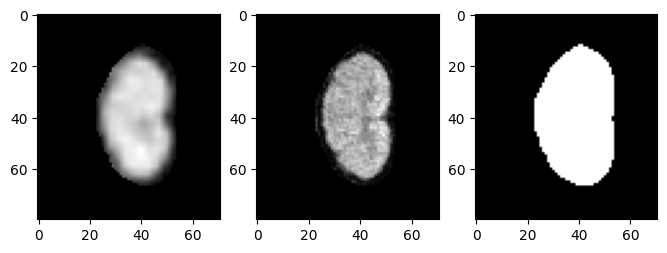

In [3]:
path_database = "/mnt/d/Poly/data_generator/pal1_reg_3T_7T"
sub = 1

image_data_3T = nib.load(path_database + "/ants_II/sub" + str(sub).zfill(2)  + '_3T_masked.nii.gz' ) # sub CT_P031
header_info_3T = image_data_3T.header
image_3T = np.array(image_data_3T.get_fdata())

image_data_7T = nib.load(path_database + "/ants_II/sub" + str(sub).zfill(2)  + '_7T_masked.nii.gz' )
image_7T = np.array(image_data_7T.get_fdata())

image_data_sc = nib.load(path_database + "/sub" + str(sub).zfill(2)  + '_7T_sc_dil.nii.gz' )
image_sc = np.array(image_data_sc.get_fdata())

print("Res :",header_info_3T['pixdim'][1:4])
print()
print("Shape :",image_7T.shape,type(image_7T.shape))

index = 7

plt.gray()
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_3T[:,:,index])
plt.subplot(1, 3, 2)
plt.imshow(image_7T[:,:,index])
plt.subplot(1, 3, 3)
plt.imshow(image_sc[:,:,index])


(64, 64, 22)


<Figure size 640x480 with 0 Axes>

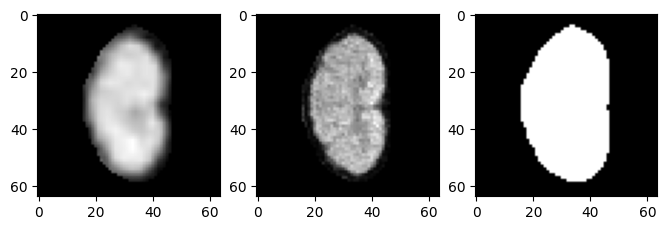

In [4]:
Size_X= 64
Size_Y= 64
Size_Z=(image_sc.shape)[2]
image_pad_3T=np.zeros((Size_X,Size_Y,Size_Z))
image_pad_7T=np.zeros((Size_X,Size_Y,Size_Z))
image_pad_sc=np.zeros((Size_X,Size_Y,Size_Z))
for i in range (Size_Z):
    image_paded_3T = np.pad(image_3T[:,:,i], 20, 'constant')
    image_paded_7T = np.pad(image_7T[:,:,i], 20, 'constant')
    image_paded_sc = np.pad(image_sc[:,:,i], 20, 'constant')
    x,y=ndimage.measurements.center_of_mass(image_paded_sc) #Definiton de center of mass 
    x,y=int(round(x)),int(round(y))
    xmin = x - int(Size_X/2)
    xmax = x + int(Size_X/2)
    ymin = y - int(Size_Y/2)
    ymax = y + int(Size_Y/2)

    image_pad_3T[:,:,i]=image_paded_3T[xmin:xmax,ymin:ymax]
    image_pad_7T[:,:,i]=image_paded_7T[xmin:xmax,ymin:ymax]
    image_pad_sc[:,:,i]=image_paded_sc[xmin:xmax,ymin:ymax]
plt.gray()
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_pad_3T[:,:,index])
plt.subplot(1, 3, 2)
plt.imshow(image_pad_7T[:,:,index])
plt.subplot(1, 3, 3)
plt.imshow(image_pad_sc[:,:,index])
print(image_pad_sc.shape)

/home/nlaines/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 640x480 with 0 Axes>

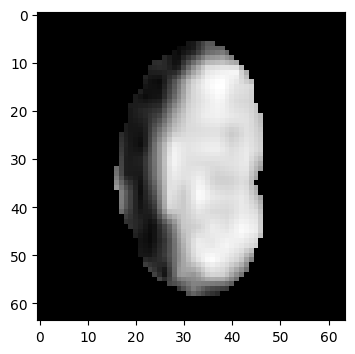

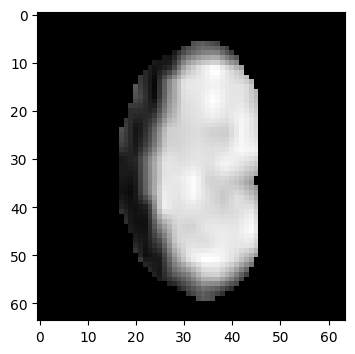

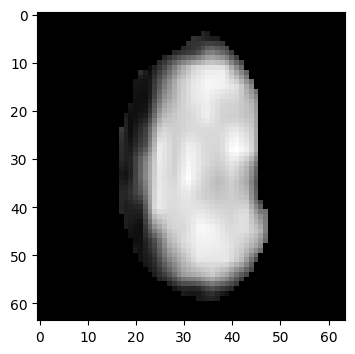

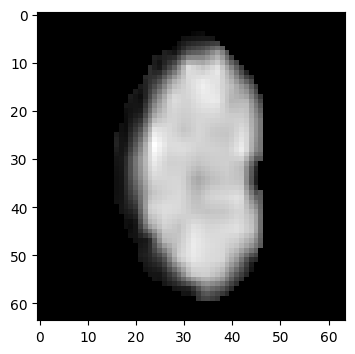

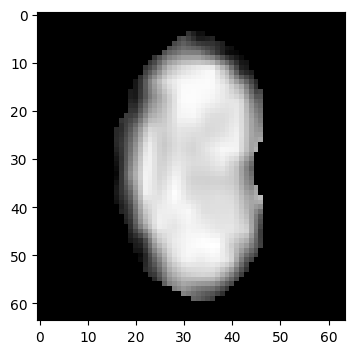

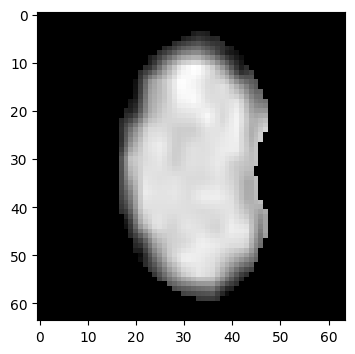

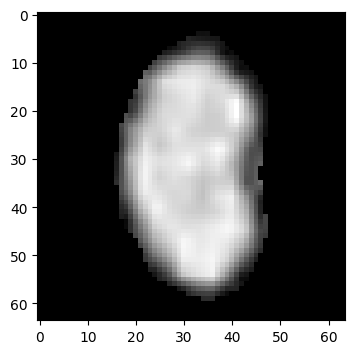

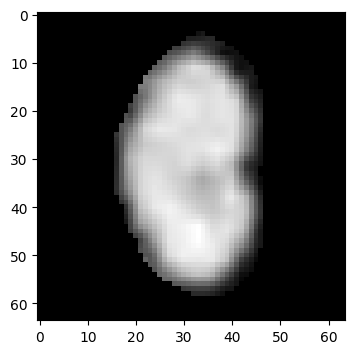

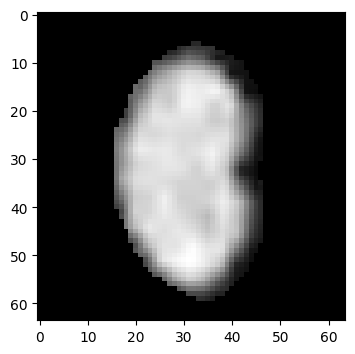

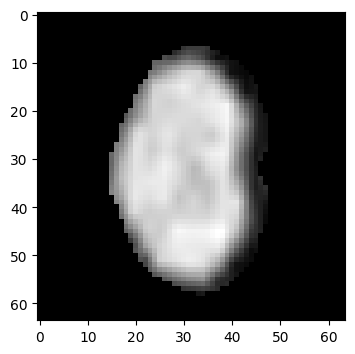

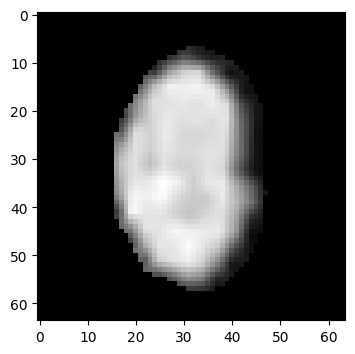

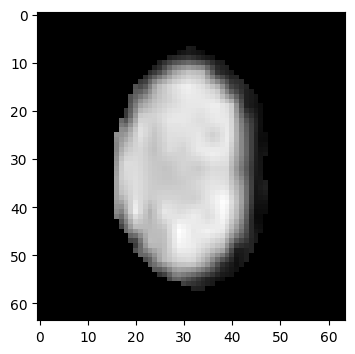

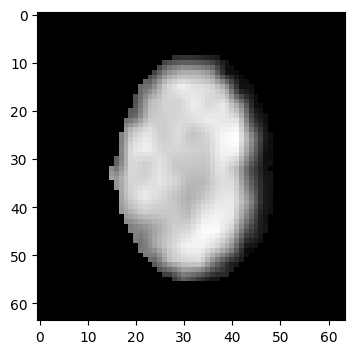

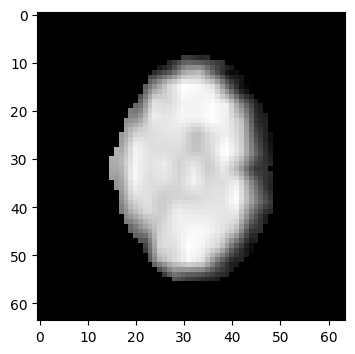

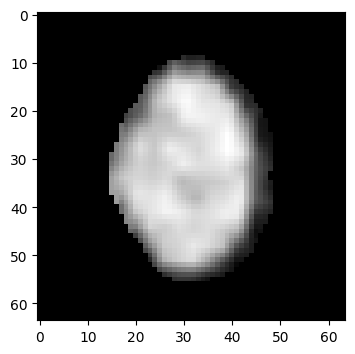

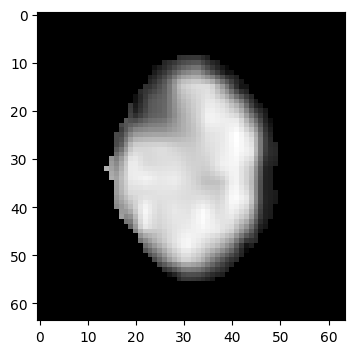

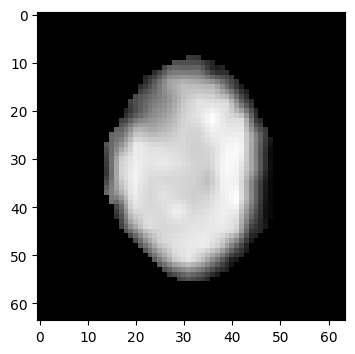

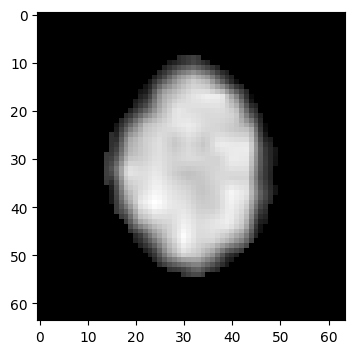

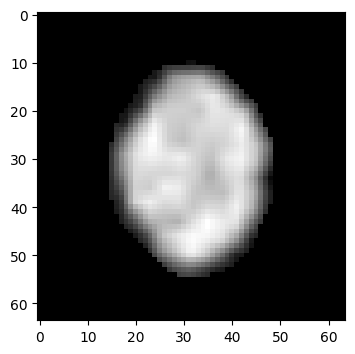

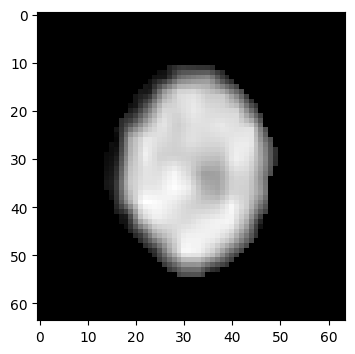

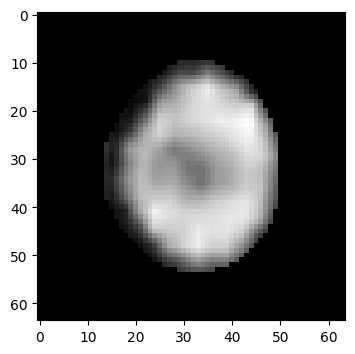

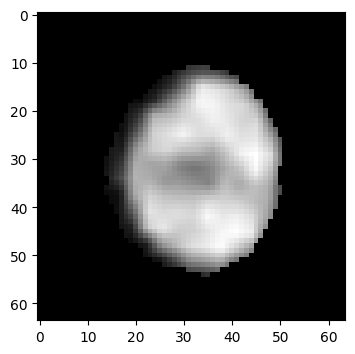

In [5]:
for slices in range (Size_Z):
    slic=image_pad_3T[:,:,slices]
    plt.gray()
    plt.figure(figsize=(4, 4))
    plt.imshow(slic)
    
    path_database_out= ("/mnt/d/Poly/data_generator/torch/")
    image_final = cv2.normalize(slic, None, -1.0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    array=image_final
    x = torch.tensor(array)
    torch.save(x, path_database_out+ 'sub-'+   str(sub).zfill(2)  + "_" + str(slices).zfill(3)+ 'M0_pal1 - 3T.pt')


/home/nlaines/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 640x480 with 0 Axes>

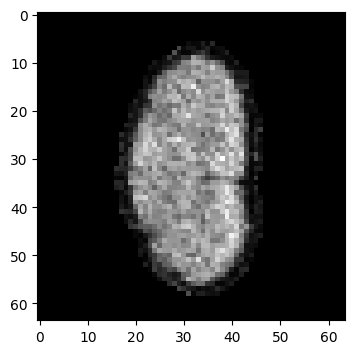

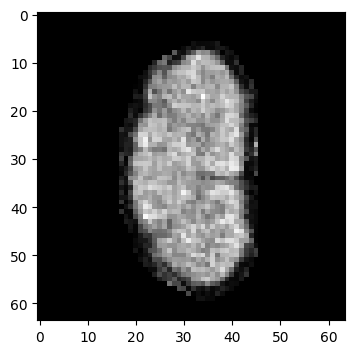

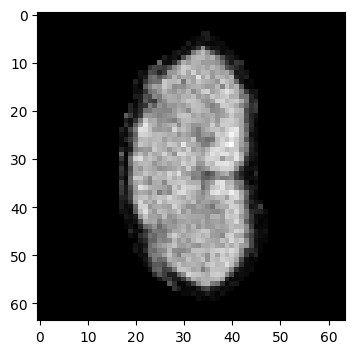

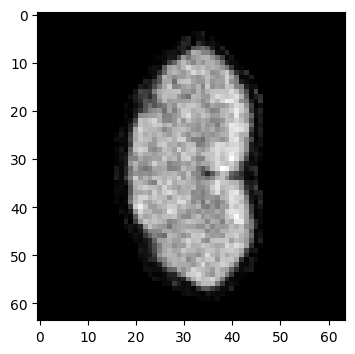

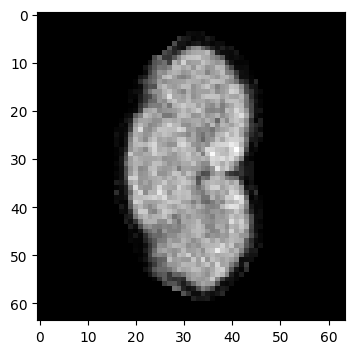

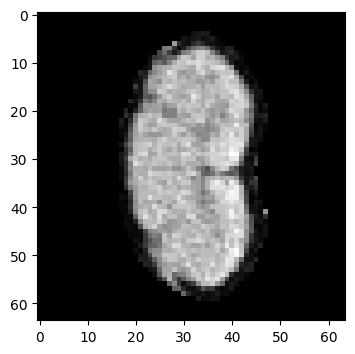

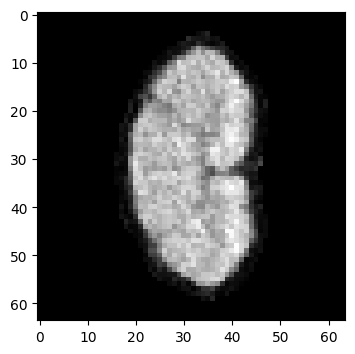

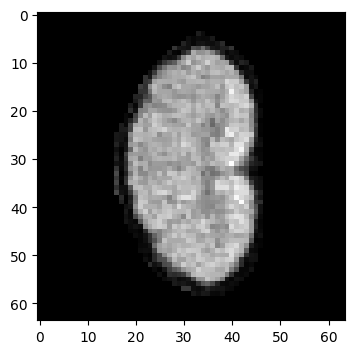

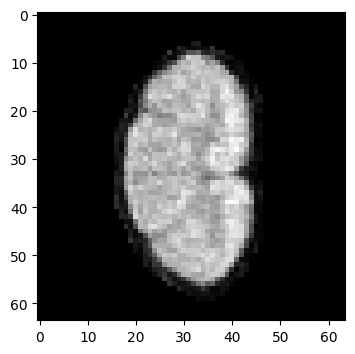

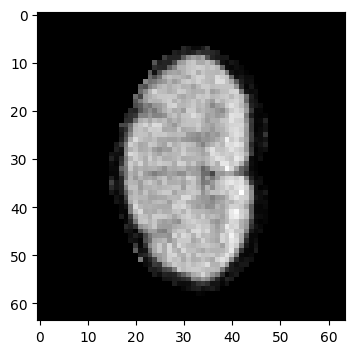

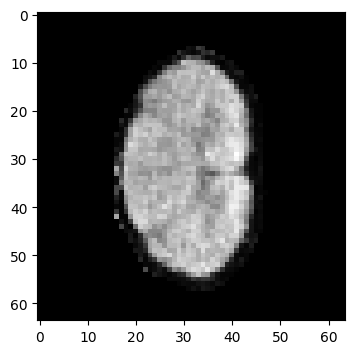

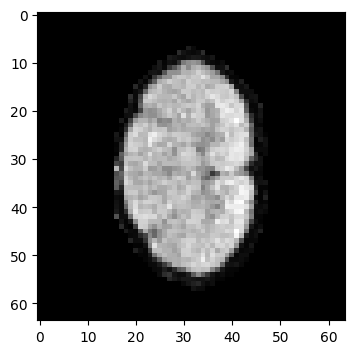

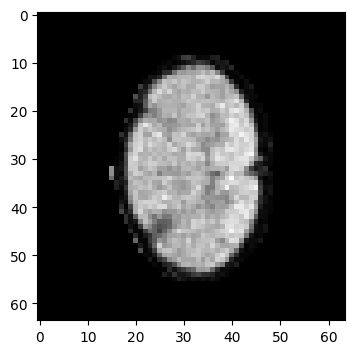

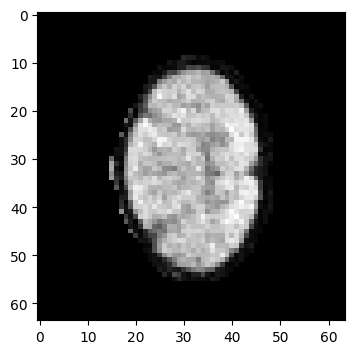

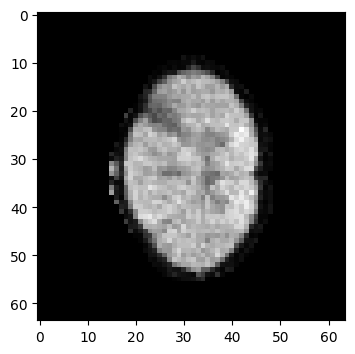

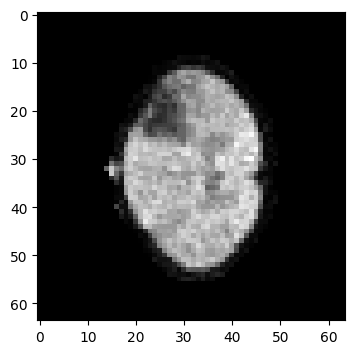

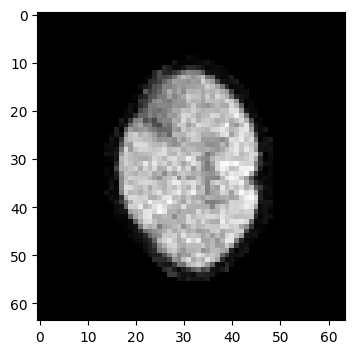

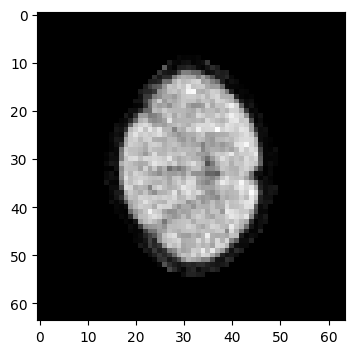

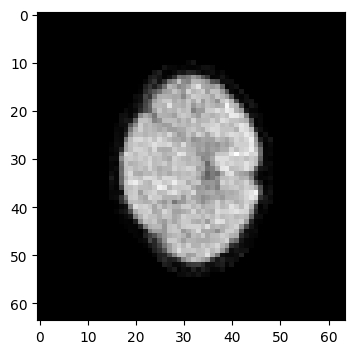

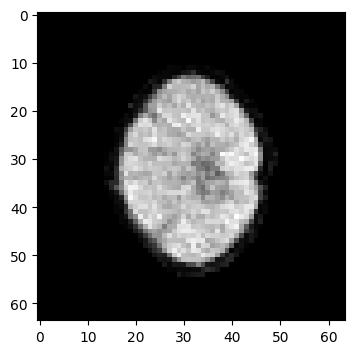

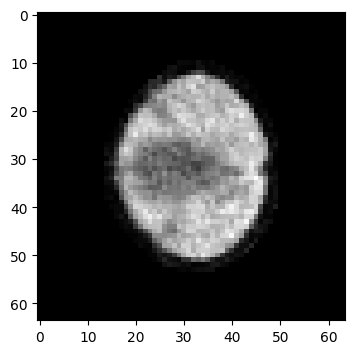

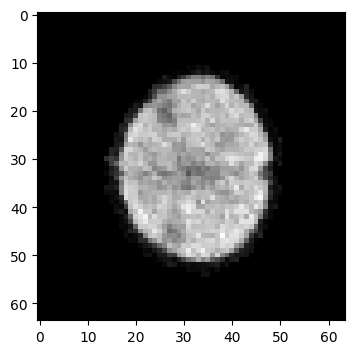

In [6]:
for slices in range (Size_Z):
    slic=image_pad_7T[:,:,slices]
    plt.gray()
    plt.figure(figsize=(4, 4))
    plt.imshow(slic)
    
    path_database_out= ("/mnt/d/Poly/data_generator/torch/")
    image_final = cv2.normalize(slic, None, -1.0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    array=image_final
    x = torch.tensor(array)
    torch.save(x, path_database_out+ 'sub-'+   str(sub).zfill(2)  + "_" + str(slices).zfill(3)+ 'M0_pal1 - 7T.pt')

## Training

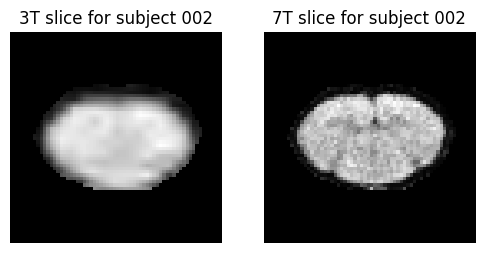

In [8]:
root = ("/mnt/d/Poly/data_generator/data_pt/")

plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-01_011M0_pal1 - 3T.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("3T slice for subject 002")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-01_011M0_pal1 - 7T.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("7T slice for subject 002")
plt.axis('off')
plt.show()

In [9]:
class Dataset3T7T (torch.utils.data.Dataset): # IXIDataset 
    def __init__(self, root, mode="train"):

        files = sorted(os.listdir(root))
        patient_id = list(set([i.split()[0] for i in files]))

        imgs = []

        if mode == "train":
            for i in patient_id[:int(0.8 * len(patient_id))]:
                if (
                    os.path.isfile(os.path.join(root, i + " - 3T.pt")) and
                    os.path.isfile(os.path.join(root, i + " - 7T.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - 3T.pt"),
                                 os.path.join(root, i + " - 7T.pt")))

        elif mode == "test":
            for i in patient_id[int(0.8 * len(patient_id)):]:
                if (
                    os.path.isfile(os.path.join(root, i + " - 3T.pt")) and
                    os.path.isfile(os.path.join(root, i + " - 7T.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - 3T.pt"),
                                 os.path.join(root, i + " - 7T.pt")))

        self.imgs = imgs

    def __getitem__(self, index):
        path_3T, path_7T = self.imgs[index]

        P_3T = torch.load(path_3T)[None, :, :]
        P_7T = torch.load(path_7T)[None, :, :]

        return {"3T": P_3T, "7T": P_7T}

    def __len__(self):
        return len(self.imgs)

In [10]:
# We provide classes for each block of the U-Net.

class UNetDown(nn.Module):
    """Descending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.LeakyReLU(0.2)
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    """Ascending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class FinalLayer(nn.Module):
    """Final block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x

In [11]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)

        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 64)

        self.final = FinalLayer(128, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)

        return self.final(u4, d1)

In [12]:
# Summary of the generator
summary(GeneratorUNet().cuda(), (1, 64, 64) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
    InstanceNorm2d-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
          UNetDown-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-6          [-1, 128, 16, 16]               0
         LeakyReLU-7          [-1, 128, 16, 16]               0
          UNetDown-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
   InstanceNorm2d-10            [-1, 256, 8, 8]               0
        LeakyReLU-11            [-1, 256, 8, 8]               0
         UNetDown-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
   InstanceNorm2d-14            [-1, 51

In [13]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()


def peak_signal_to_noise_ratio(image_true, image_generated):
    """"Compute peak signal-to-noise ratio.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        psnr: (float) peak signal-to-noise ratio"""
    mse = ((image_true - image_generated) ** 2).mean().cpu()
    return -10 * np.log10(mse)


def structural_similarity_index(image_true, image_generated, C1=0.01, C2=0.03):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator
        C2: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = ((mean_true ** 2 + mean_generated ** 2 + C1) *
                   (std_true ** 2 + std_generated ** 2 + C2))
    return numerator / denominator

In [14]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating  images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_loader):

            real_3T = batch["3T"].type(Tensor)
            real_7T = batch["7T"].type(Tensor)
            fake_7T = generator(real_3T)

            mae = mean_absolute_error(real_7T, fake_7T).item()
            psnr = peak_signal_to_noise_ratio(real_7T, fake_7T).item()
            ssim = structural_similarity_index(real_7T, fake_7T).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(test_loader):

            real_3T = batch["3T"].type(Tensor)
            real_7T = batch["7T"].type(Tensor)
            fake_7T = generator(real_3T)

            mae = mean_absolute_error(real_7T, fake_7T).item()
            psnr = peak_signal_to_noise_ratio(real_7T, fake_7T).item()
            ssim = structural_similarity_index(real_7T, fake_7T).item()

            res_test.append([mae, psnr, ssim])

        df = pd.DataFrame([
            pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
            pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
        ], index=['Training set', 'Test set']).T
    return df

In [15]:
# We provide a function to generate a block for the given architecture.
def discriminator_block(in_filters, out_filters):
    """Return downsampling layers of each discriminator block"""
    layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)


class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            discriminator_block(in_channels*2, 64),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            discriminator_block(256, 512),
            nn.Conv2d(512, 1, 1, stride=4, padding=0),
        )


    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.layers(img_input)

In [16]:
# Summary of the discriminator
summary(Discriminator().cuda(), [(1, 64, 64), (1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,216
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
         LeakyReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5            [-1, 256, 8, 8]         295,168
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 4, 4]       1,180,160
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]             513
Total params: 1,550,913
Trainable params: 1,550,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 64.00
Forward/backward pass size (MB): 1.88
Params size (MB): 5.92
Estimated Total Size (MB): 71.79
-------------------------------------

In [17]:
def train_cgan(train_loader, test_loader, num_epoch=500,
               lr=0.0001, beta1=0.9, beta2=0.999):
    """Train a conditional GAN.

    Args:
        train_loader: (DataLoader) a DataLoader wrapping a the training dataset
        test_loader: (DataLoader) a DataLoader wrapping a the test dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the trained generator
    """

    cuda = True if torch.cuda.is_available() else False
    print(f"Using cuda device: {cuda}")  # check if GPU is used

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Output folder
    if not os.path.exists("./images/cgan"):
        os.makedirs("./images/cgan")

    # Loss functions
    criterion_GAN = torch.nn.BCEWithLogitsLoss()  # A loss adapted to binary classification like torch.nn.BCEWithLogitsLoss
    criterion_pixelwise = torch.nn.L1Loss()  # A loss for a voxel-wise comparison of images like torch.nn.L1Loss

    lambda_GAN = 1.  # Weights criterion_GAN in the generator loss
    lambda_pixel = 1.  # Weights criterion_pixelwise in the generator loss

    # Initialize generator and discriminator
    generator = GeneratorUNet()
    discriminator = Discriminator()

    if cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        criterion_GAN.cuda()
        criterion_pixelwise.cuda()

    # Optimizers
    optimizer_generator = torch.optim.Adam(
        generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_discriminator = torch.optim.Adam(
        discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_3T = imgs["3T"].type(Tensor)
        real_7T = imgs["7T"].type(Tensor)
        fake_7T = generator(real_3T)
        img_sample = torch.cat((real_3T.data, fake_7T.data, real_7T.data), -2)
        save_image(img_sample, f"./images/cgan/epoch-{epoch}.png",
                   nrow=5, normalize=True)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()
###
    loss_discri = []
    loss_gener = []
    loss_pix = []
    loss_gan = []
###
    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            real_3T = batch["3T"].type(Tensor)
            real_7T = batch["7T"].type(Tensor)

            # Create labels
            valid = Tensor(np.ones((real_7T.size(0), 1, 1, 1)))
            fake = Tensor(np.zeros((real_7T.size(0), 1, 1, 1)))

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_generator.zero_grad()

            # GAN loss
            fake_7T = generator(real_3T)
            pred_fake = discriminator(fake_7T, real_3T)
            loss_GAN = criterion_GAN(pred_fake, valid)

            # L1 loss
            loss_pixel = criterion_pixelwise(fake_7T, real_7T)

            # Total loss
            loss_generator = lambda_GAN * loss_GAN + lambda_pixel * loss_pixel

            # Compute the gradient and perform one optimization step
            loss_generator.backward()
            optimizer_generator.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_discriminator.zero_grad()

            # Real loss
            pred_real = discriminator(real_7T, real_3T)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake loss
            fake_7T = generator(real_3T)
            pred_fake = discriminator(fake_7T.detach(), real_3T)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total loss
            loss_discriminator = 0.5 * (loss_real + loss_fake)

            # Compute the gradient and perform one optimization step
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            ###           

            loss_discri.append(loss_discriminator)
            loss_gener.append(loss_generator)
            loss_pix.append(loss_pixel)
            loss_gan.append(loss_GAN)
            ###
            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] "
                "[G loss: %f, pixel: %f, adv: %f] ETA: %s"
                % (
                    epoch + 1,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss_discriminator.item(),
                    loss_generator.item(),
                    loss_pixel.item(),
                    loss_GAN.item(),
                    time_left,
                )
            )

        # Save images at the end of each epoch
        sample_images(epoch)

    return generator, loss_discri, loss_gener, loss_pix, loss_gan 

In [18]:
# Create dataloaders
batch_size = 16
train_loader = DataLoader(Dataset3T7T(root, mode="train"),
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(Dataset3T7T(root, mode="test"),
                         batch_size=5,
                         shuffle=False)
# Number of epochs
num_epoch = 250
# Parameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

In [396]:
generator_cgan, loss_discri, loss_gener, loss_pix, loss_gan = train_cgan(train_loader, test_loader, num_epoch=num_epoch,
                            lr=lr, beta1=beta1, beta2=beta2)

Using cuda device: True
[Epoch 250/250] [Batch 20/21] [D loss: 0.693148] [G loss: 0.704041, pixel: 0.010993, adv: 0.693048] ETA: 0:00:00.070908

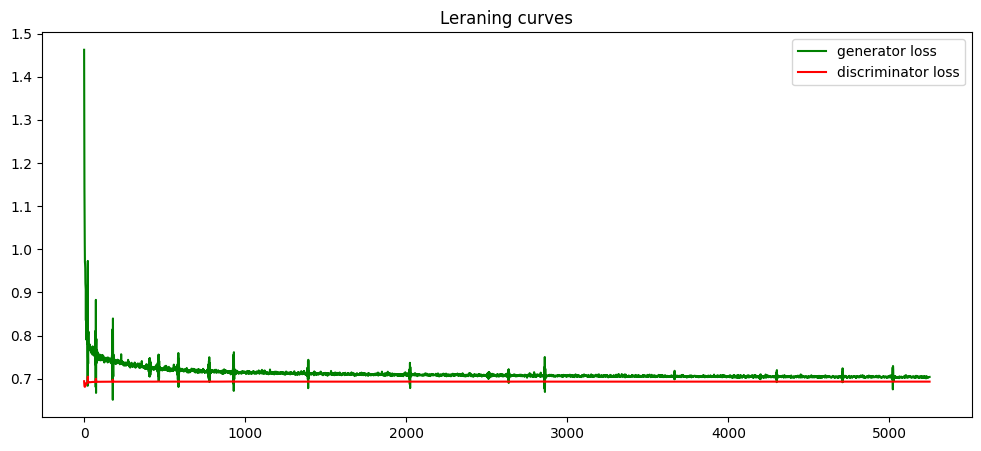

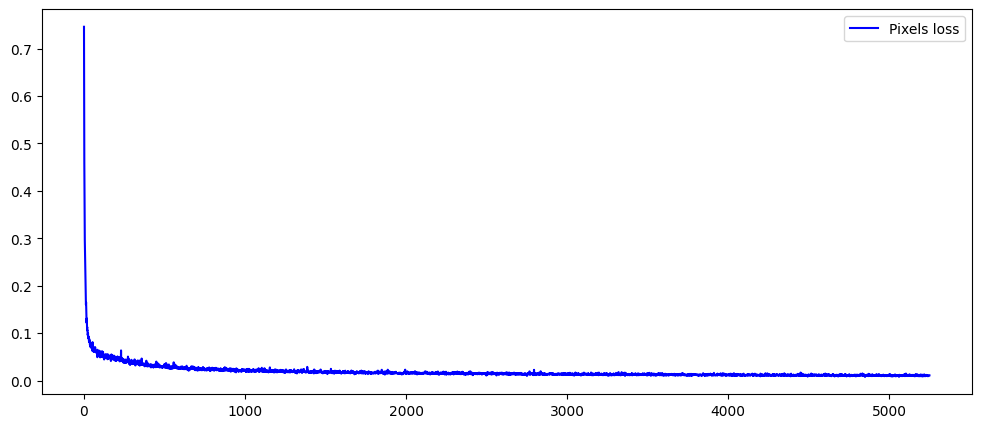

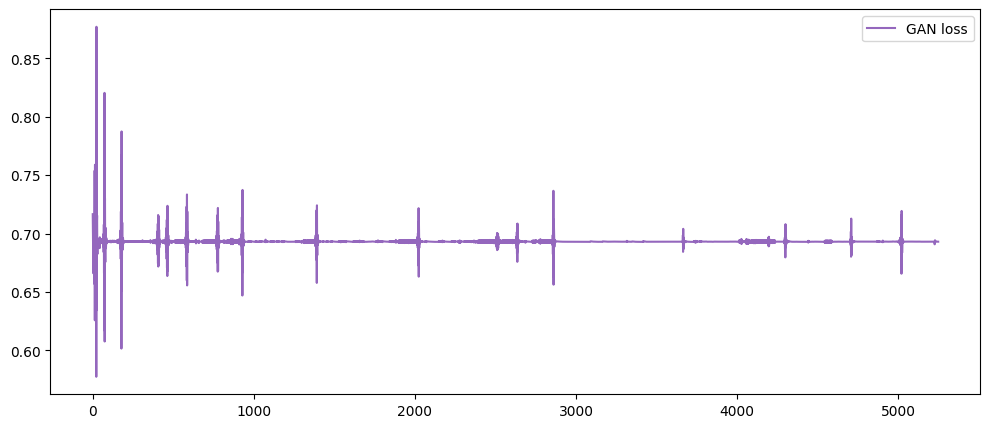

In [398]:
# Learing curves 
a = []
b = []
c = []
d = []
for i in range (len(loss_discri)):
    a.append(np.array(loss_discri[i].detach().cpu()))
    b.append(np.array(loss_gener[i].detach().cpu()))
    c.append(np.array(loss_pix[i].detach().cpu()))
    d.append(np.array(loss_gan[i].detach().cpu()))

plt.figure(figsize=(12,5))
plt.title('Leraning curves')
plt.plot(b ,  color='g', label='generator loss')
plt.plot(a ,  color='r', label='discriminator loss')
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.plot(c  ,  color='b', label='Pixels loss')
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.plot(d  ,  color='C4', label='GAN loss')
plt.legend()
plt.show()

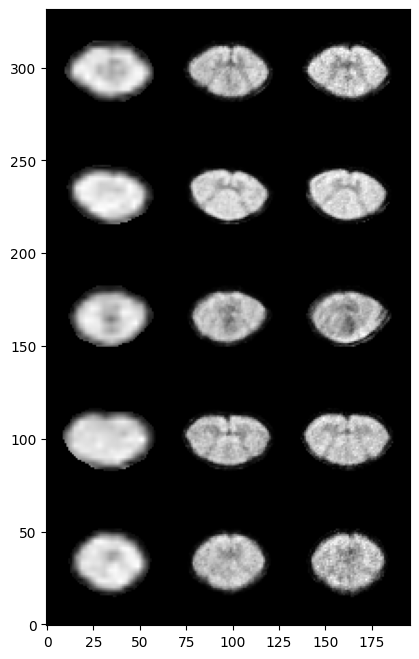

In [399]:
plt.figure(figsize=(8, 8))
im = img.imread(f'./images/cgan/epoch-{num_epoch - 1}.png')
plt.imshow(np.swapaxes(im, 0, 1))
plt.gca().invert_yaxis()
plt.show()

In [400]:
evaluate_generator(generator_cgan)

Training set   Test set
MAE       0.010262   0.049137
PSNR     31.293581  18.406841
SSIM      0.998896   0.973741

In [401]:
patch = "/mnt/d/Poly/data_generator/"
torch.save(generator_cgan,patch + 'generator_cgan_250_epoch.pt')

In [402]:
#patch='/mnt/d/Poly/test_gan/'
#model_gan=torch.load(patch+'generator_cgan_100.pt')

Text(0.5, 1.0, 'true')

<Figure size 640x480 with 0 Axes>

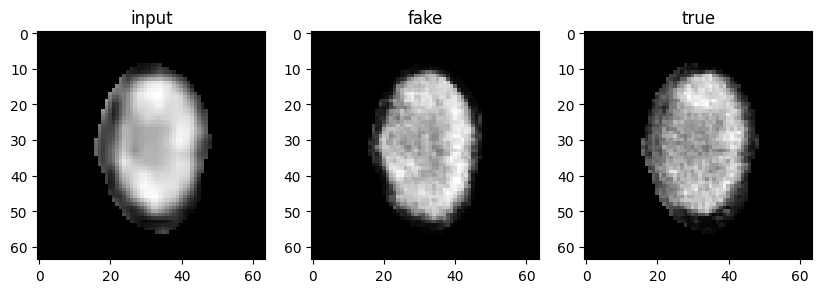

In [403]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
patch = "/mnt/d/Poly/data_generator/torch/"

imag_test=torch.load(os.path.join(patch, 'sub-11_011M0_pal2 - 3T.pt'))
imag_true=torch.load(os.path.join(patch, 'sub-11_011M0_pal2 - 7T.pt'))
#imgs = next(iter(test_loaders))
imag_test = imag_test[None, None, :]
real = imag_test.type(Tensor)
fake = generator_cgan(real)
fake=fake[0,0,:,:].cpu().detach().numpy()
plt.gray()
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(real[0,0,:,:].cpu().detach().numpy() )
plt.title("input")
#plt.show()
#fake_B=fake_B.Tensor.cpu()
plt.subplot(1, 3, 2)
plt.imshow(fake)
plt.title("fake")
#plt.show()
#fake_B=fake_B.Tensor.cpu()
plt.subplot(1, 3, 3)
plt.imshow(imag_true[:,:].cpu().detach().numpy() )
plt.title("true")

Text(0.5, 1.0, 'true')

<Figure size 640x480 with 0 Axes>

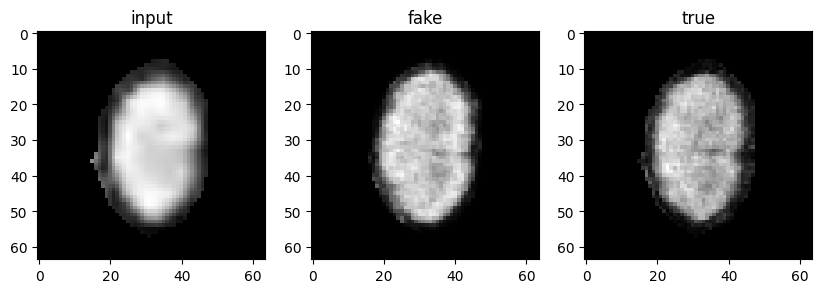

In [407]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

imag_test=torch.load(os.path.join(patch, 'sub-11_009M0_pal2 - 3T.pt'))
imag_true=torch.load(os.path.join(patch, 'sub-11_009M0_pal2 - 7T.pt'))
#imgs = next(iter(test_loaders))
imag_test = imag_test[None, None, :]
real = imag_test.type(Tensor)
fake = generator_cgan(real)
fake=fake[0,0,:,:].cpu().detach().numpy()
plt.gray()
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(real[0,0,:,:].cpu().detach().numpy() )
plt.title("input")
#plt.show()
#fake_B=fake_B.Tensor.cpu()
plt.subplot(1, 3, 2)
plt.imshow(fake)
plt.title("fake")
#plt.show()
#fake_B=fake_B.Tensor.cpu()
plt.subplot(1, 3, 3)
plt.imshow(imag_true[:,:].cpu().detach().numpy() )
plt.title("true")

# Test on 3T MP2RAGE Basel dataset

Text(0.5, 1.0, 'fake')

<Figure size 640x480 with 0 Axes>

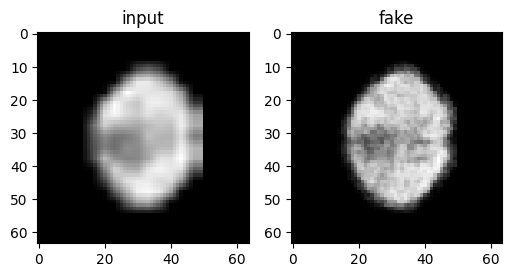

In [408]:
generator_cgan = generator_cgan

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
patch = '/mnt/d/Poly/test_gan/'
imag_test=torch.load(os.path.join(patch, "sub-01_058 - T1.pt"))
#imgs = next(iter(test_loaders))
imag_test = imag_test[None, None, :]
real = imag_test.type(Tensor)
fake = generator_cgan(real)
fake=fake[0,0,:,:].cpu().detach().numpy()
plt.gray()
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.imshow(real[0,0,:,:].cpu().detach().numpy() )
plt.title("input")
plt.subplot(1, 2, 2)
plt.imshow(fake)
plt.title("fake")

In [409]:
# MS PATIENT
patch = '/mnt/d/Poly/test_gan/'
image_data_LE = nib.load(patch + 'sub-P011_UNIT1_masked.nii.gz' ) 
header_info_LE = image_data_LE.header
image_3TMP2RAGE = np.array(image_data_LE.get_fdata())

image_data_sc = nib.load(patch + 'sub-P011_UNIT1_sc_masked.nii.gz' ) 
image_sc = np.array(image_data_sc.get_fdata())

image_data_lesion = nib.load(patch + 'sub-P011_UNIT1_lesion_masked.nii.gz' ) 
image_lesion = np.array(image_data_lesion.get_fdata())
max_pixel = np.max(image_3TMP2RAGE)
print (image_lesion.shape , "  / max value = " , max_pixel)


(97, 93, 78)   / max value =  3086.0


(197, 193, 78)


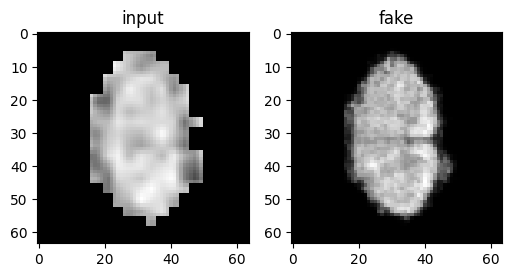

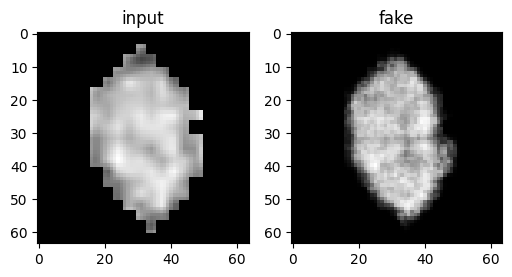

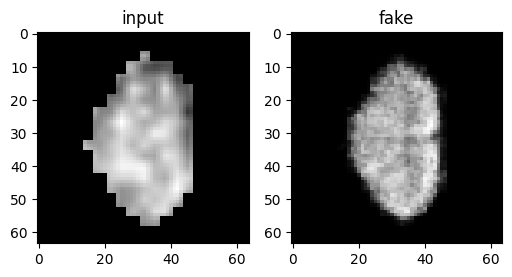

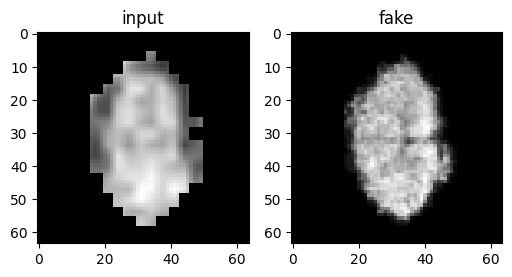

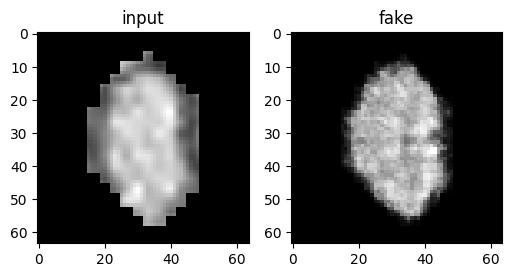

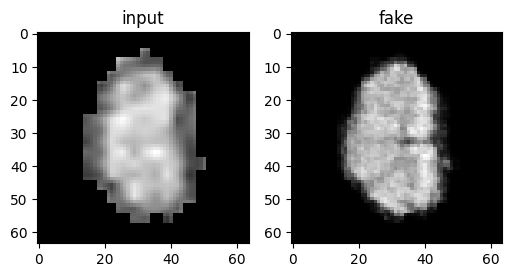

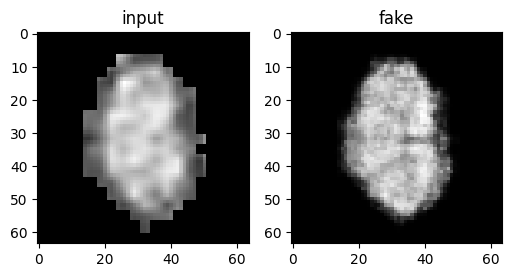

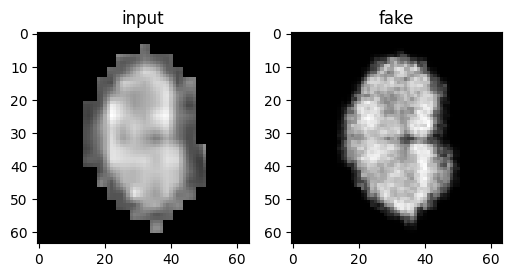

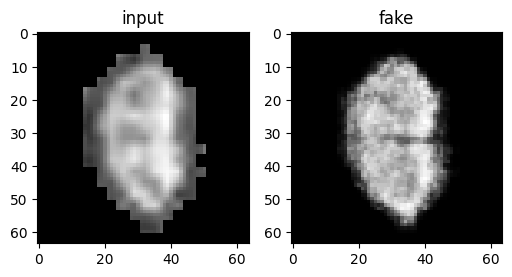

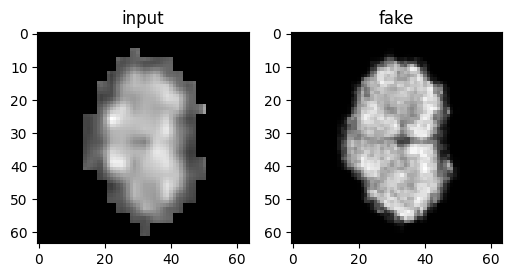

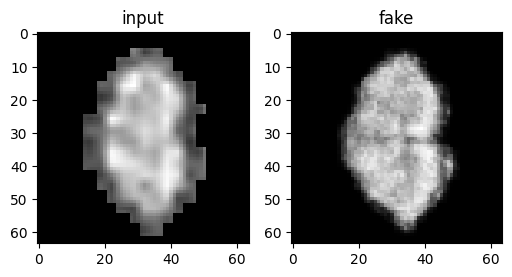

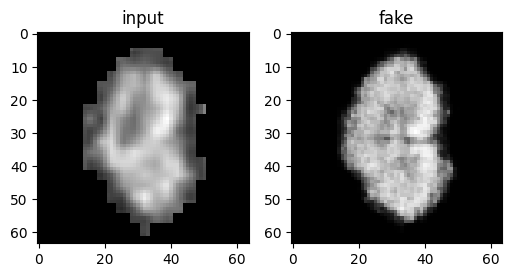

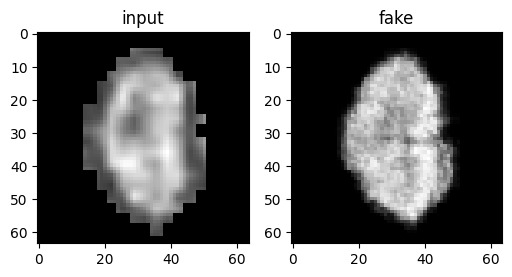

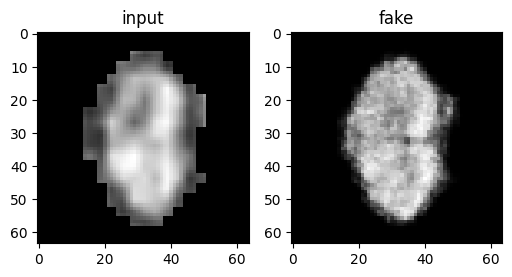

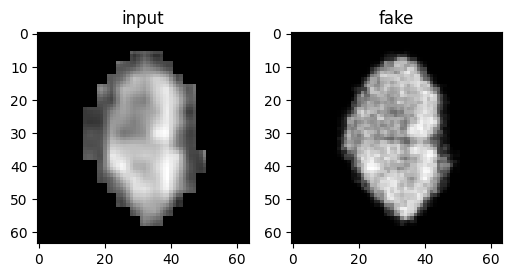

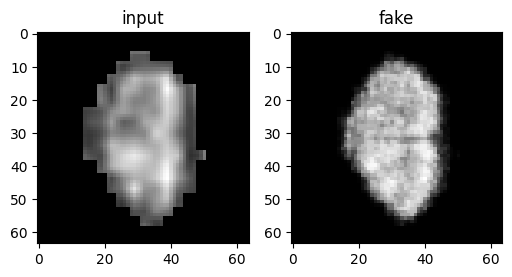

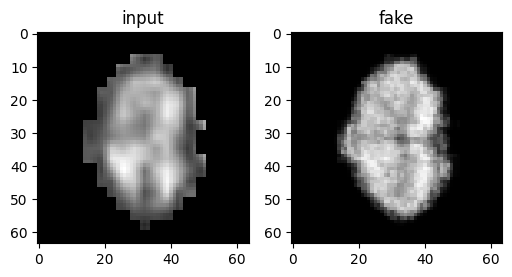

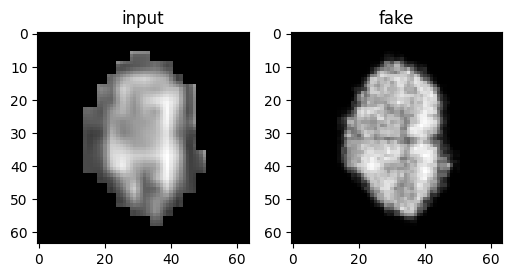

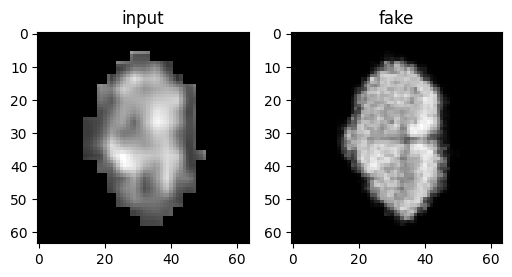

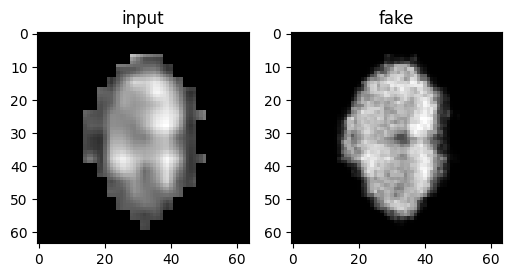

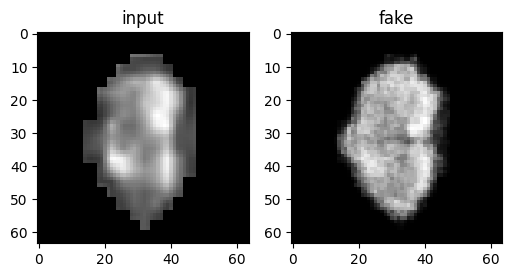

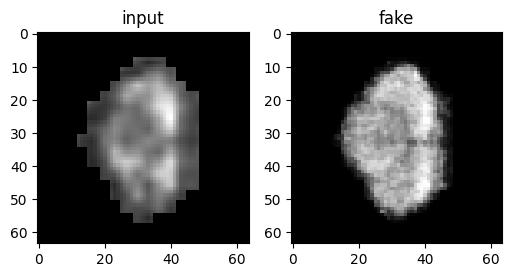

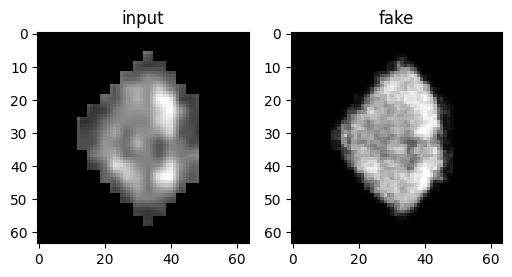

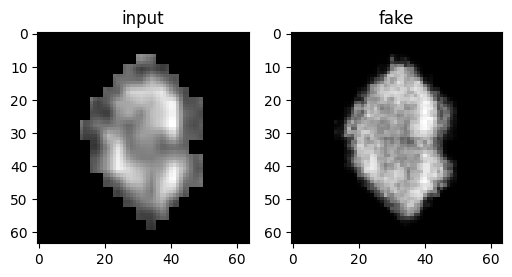

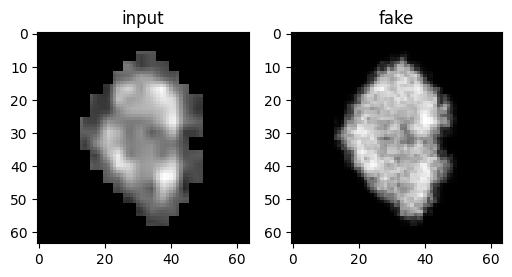

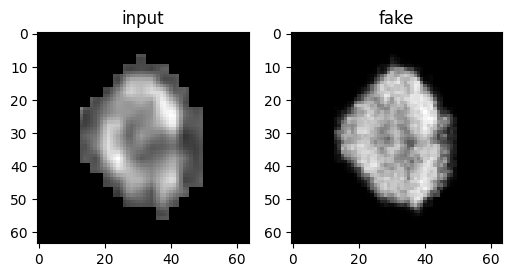

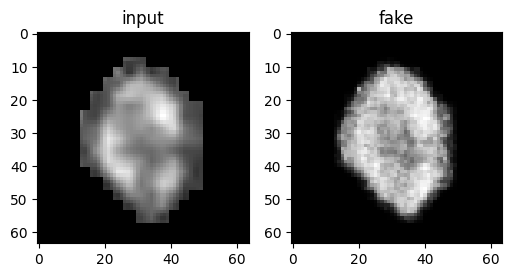

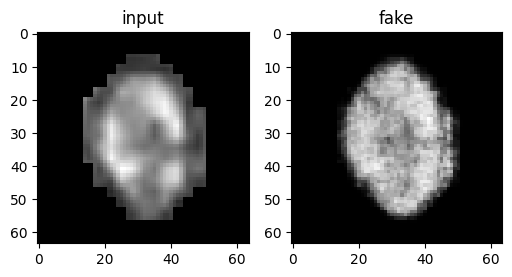

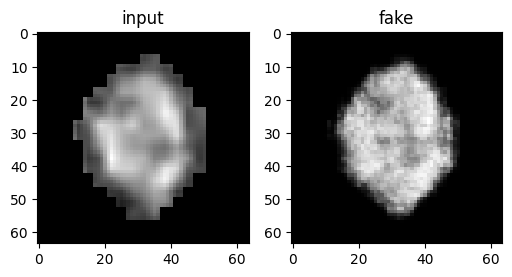

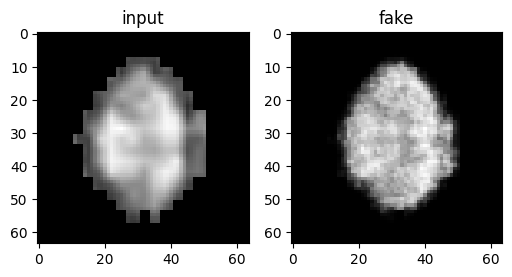

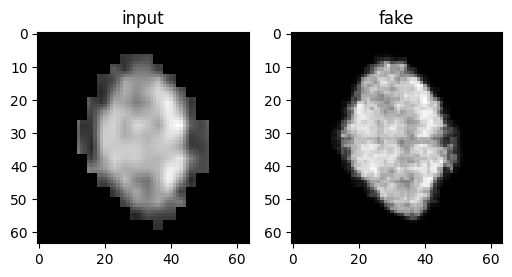

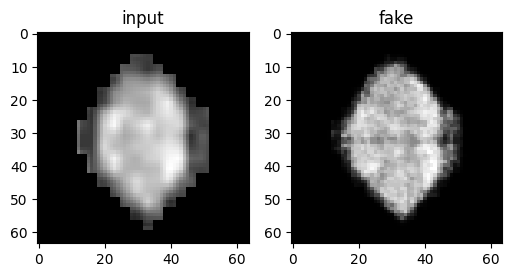

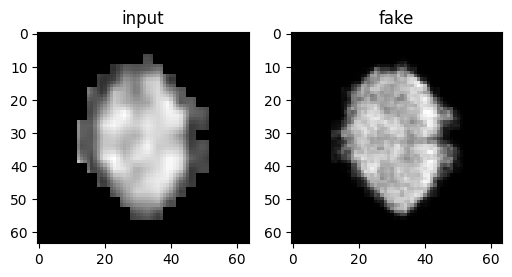

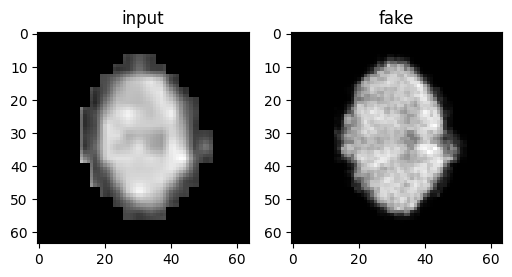

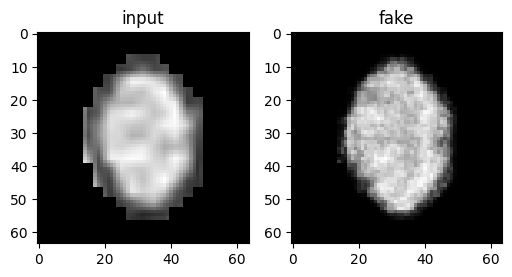

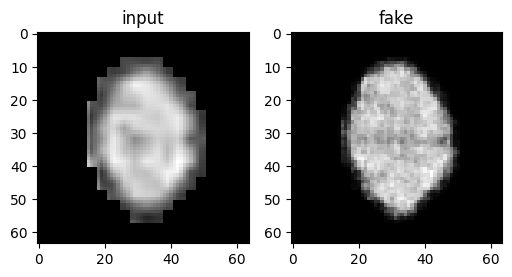

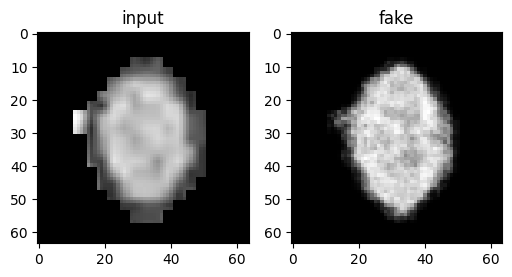

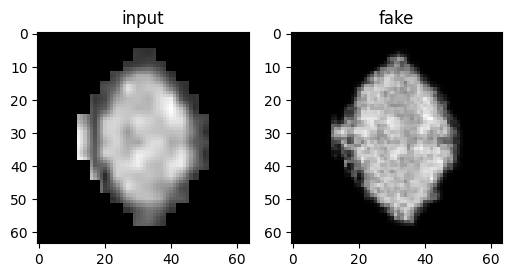

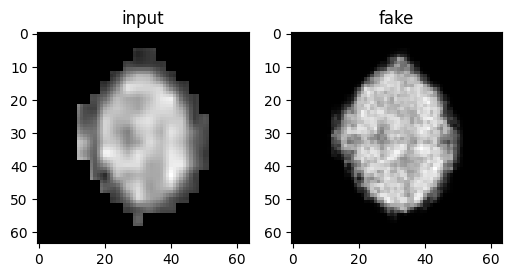

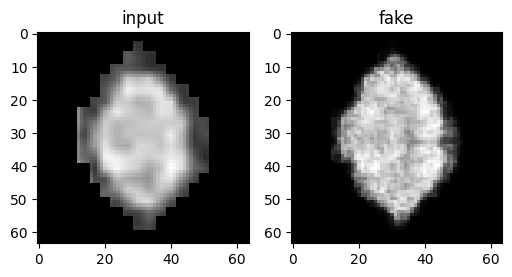

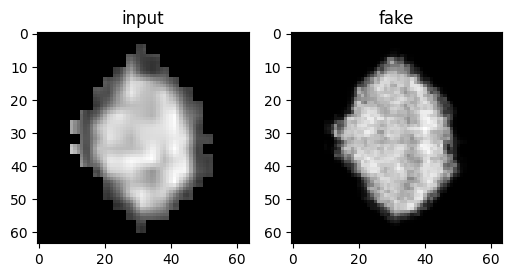

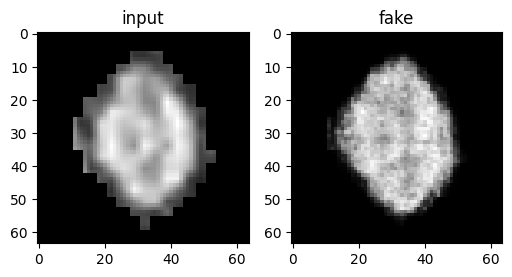

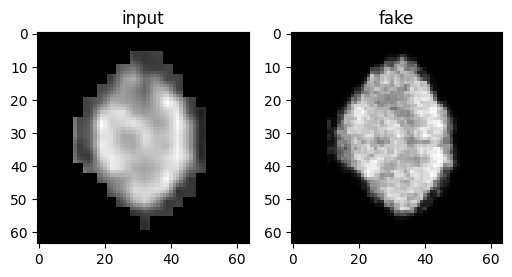

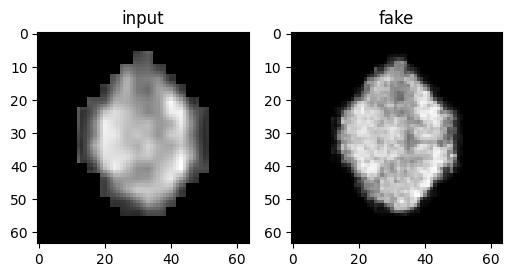

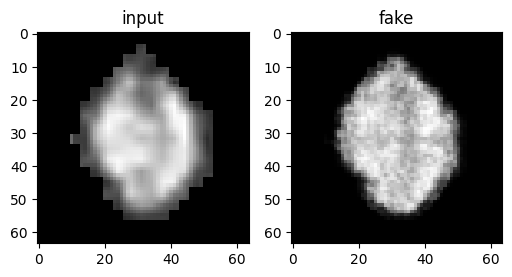

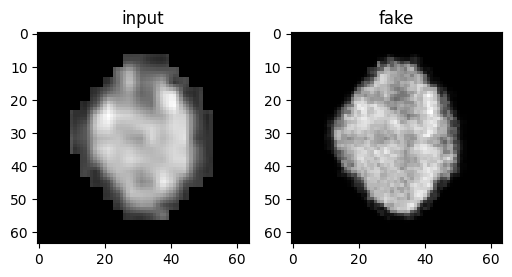

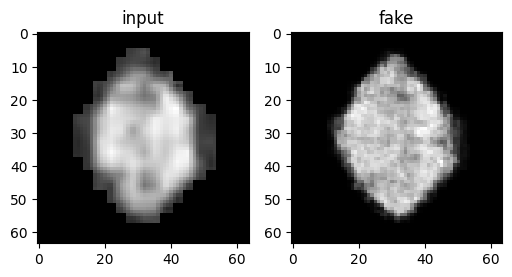

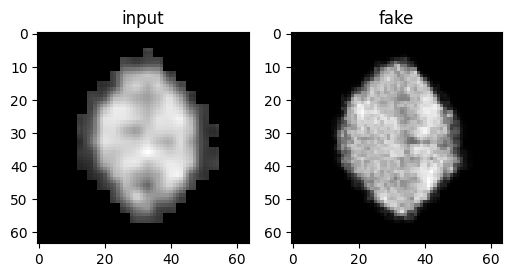

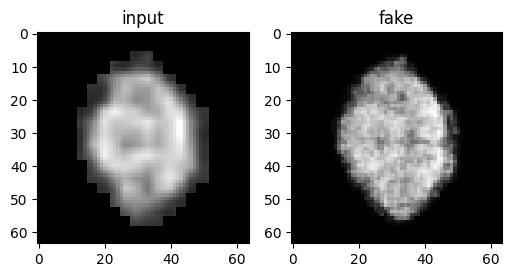

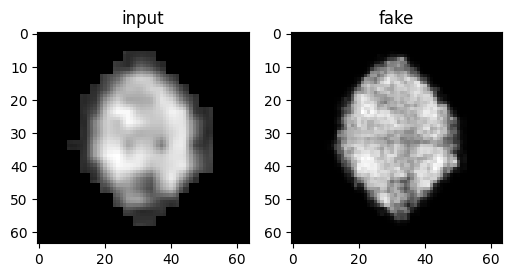

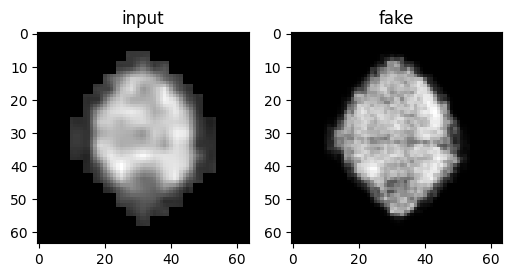

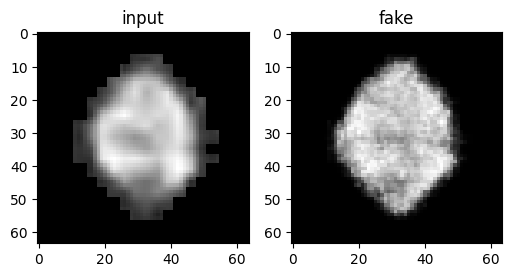

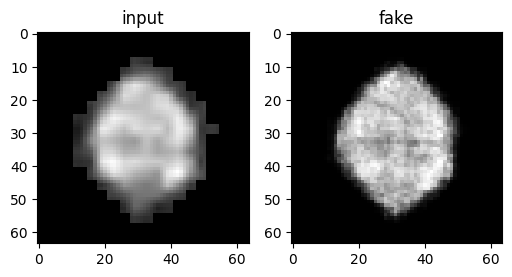

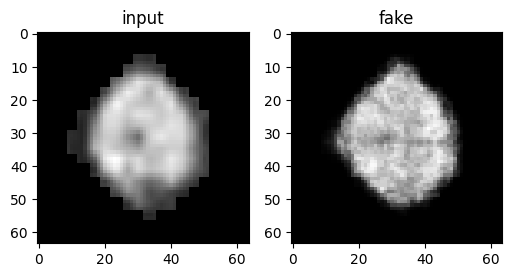

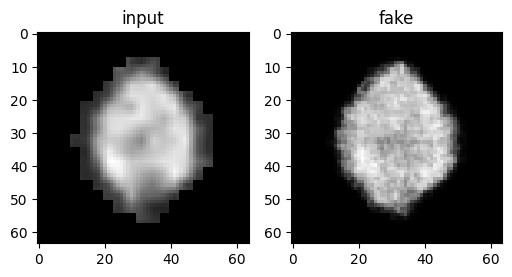

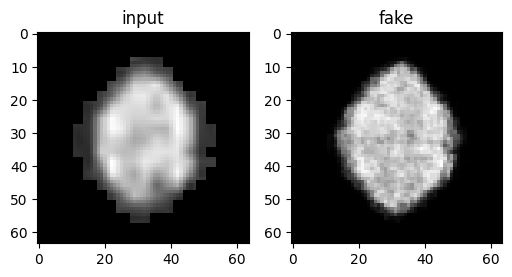

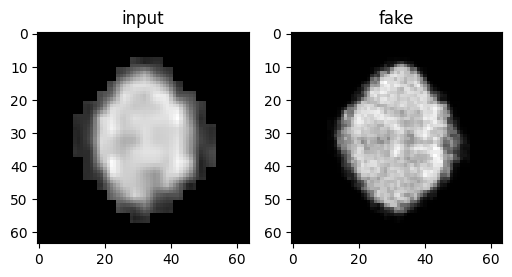

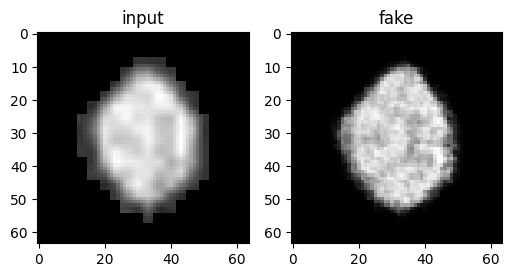

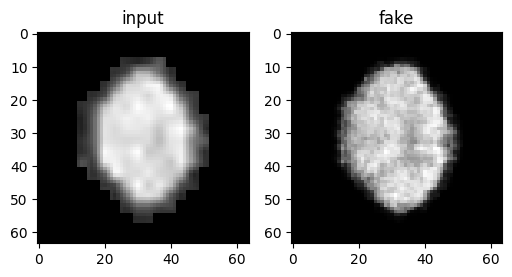

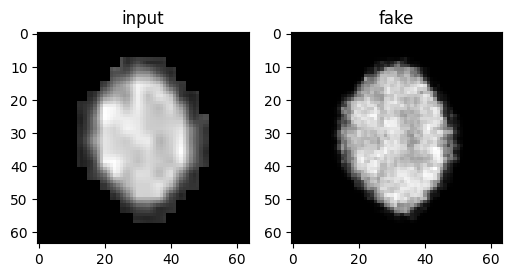

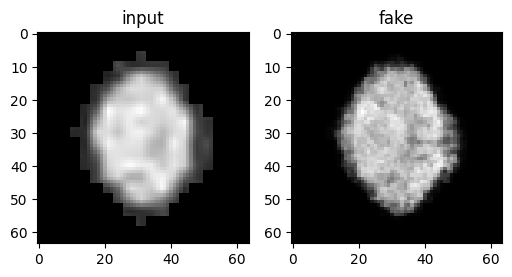

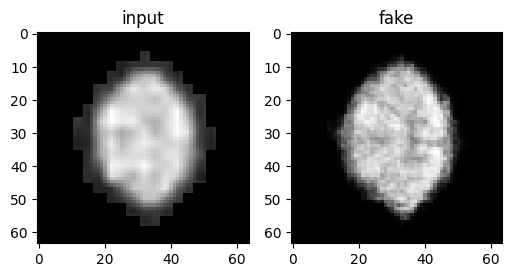

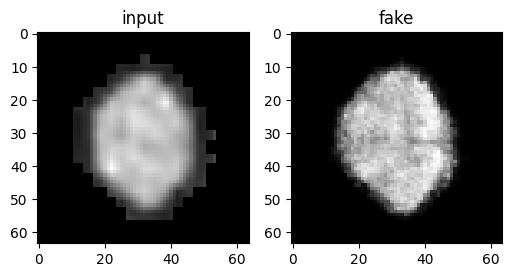

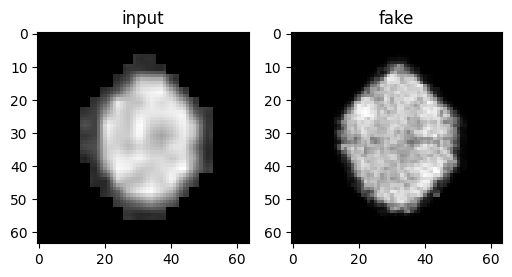

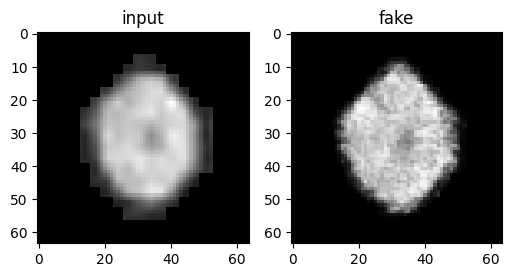

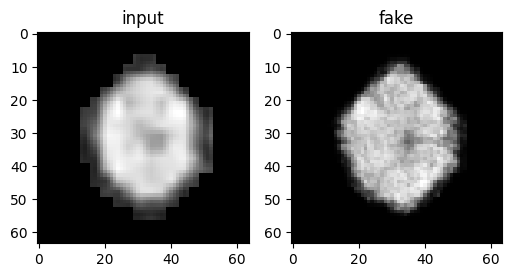

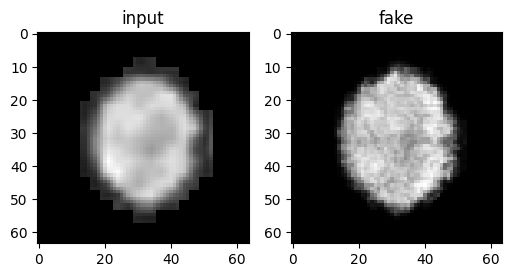

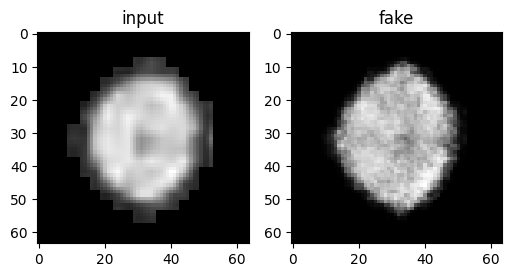

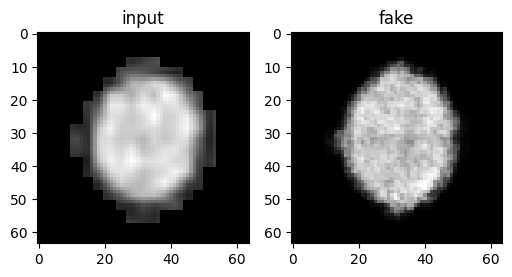

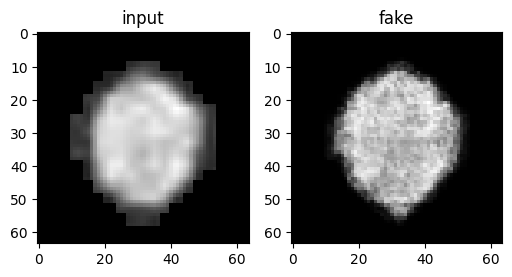

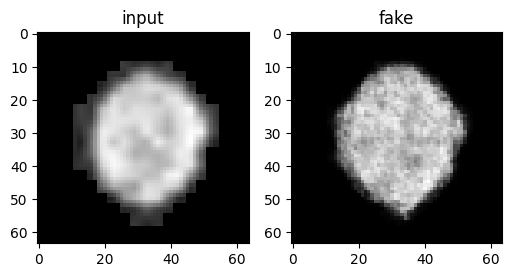

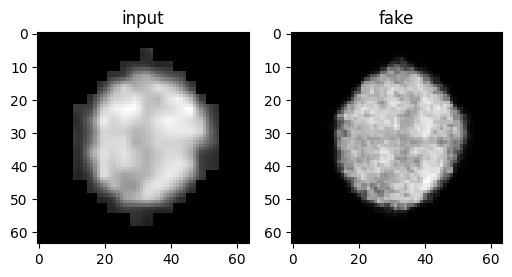

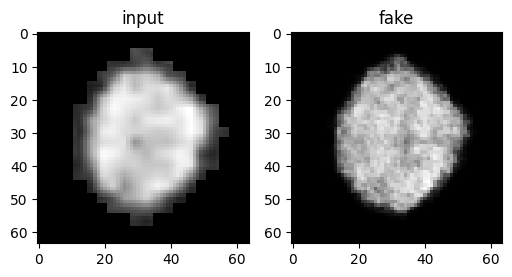

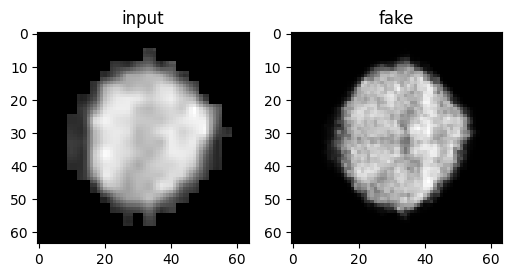

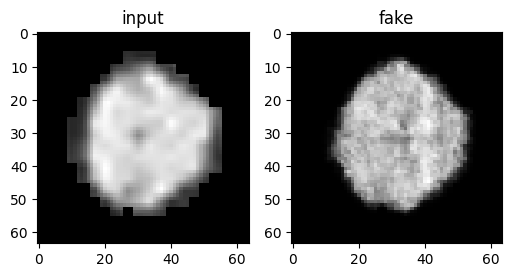

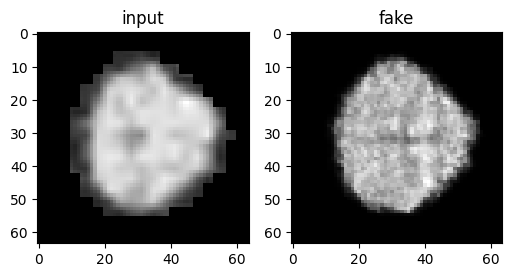

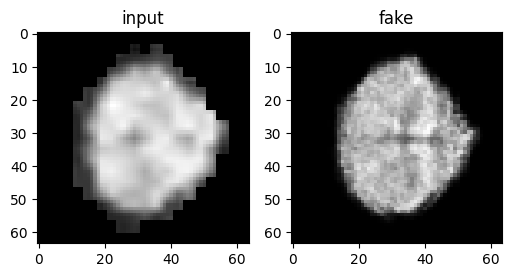

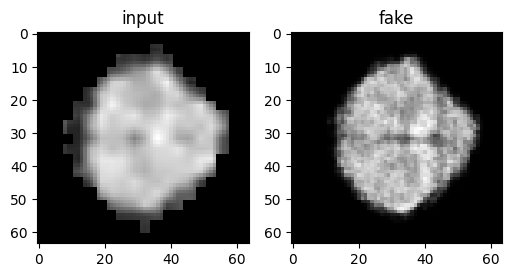

In [410]:
generator_cgan = generator_cgan

Size_X= 64
Size_Y= 64
Size_Z=(image_sc.shape)[2]
image_pad_3TMP2RAGE=np.zeros((Size_X,Size_Y,Size_Z))
padding_x_y = ((50, 50), (50, 50), (0, 0))
image_paded_3TMP2RAGE = np.pad(image_3TMP2RAGE, padding_x_y , 'constant')    
image_paded_sc = np.pad(image_sc, padding_x_y , 'constant')   
image_paded_lesion = np.pad(image_lesion, padding_x_y , 'constant')   

image_paded_center = np.zeros(image_paded_3TMP2RAGE.shape)
print (image_paded_3TMP2RAGE.shape)
for i in range (Size_Z):
    x,y=ndimage.measurements.center_of_mass(image_paded_sc[:,:,i])
    x,y=int(round(x)),int(round(y))
    xmin = x - 32
    xmax = x + 32
    ymin = y - 32
    ymax = y + 32
    array=image_paded_3TMP2RAGE[xmin:xmax,ymin:ymax,i] 
    x = torch.tensor(array)
    x_new = x[None, None, :]
    Size_X=(x_new.shape)[2]
    Size_Y=(x_new.shape)[3]
    Size_Z= 1
    d = generator_cgan(x_new[:,:,:].type(Tensor)).cpu().detach().numpy()
    image_pad_3TMP2RAGE[:,:,i]=d
    padding_x_y_ii = ((xmin, image_paded_3TMP2RAGE.shape[0] - xmax), (ymin, image_paded_3TMP2RAGE.shape[1] - ymax) )
    image_paded_center[:,:,i] = np.pad(image_pad_3TMP2RAGE[:,:,i], padding_x_y_ii , 'constant', constant_values=-1) 
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x_new[0,0,:,:])
    plt.title("input")
    plt.subplot(1, 2, 2)
    plt.imshow((image_pad_3TMP2RAGE[:,:,i]))
    plt.title("fake")
    plt.show()

In [412]:
patch = '/mnt/d/Poly/test_gan/'
image_data_LE = nib.load(patch + 'sub-C011_UNIT1_masked.nii.gz' ) 
header_info_LE = image_data_LE.header
image_3TMP2RAGE = np.array(image_data_LE.get_fdata())

image_data_sc = nib.load(patch + 'sub-C011_UNIT1_sc_masked.nii.gz' ) 
image_sc = np.array(image_data_sc.get_fdata())

print (image_lesion.shape , "  / max value = " , max_pixel)

(97, 93, 78)   / max value =  3086.0


(183, 197, 101)


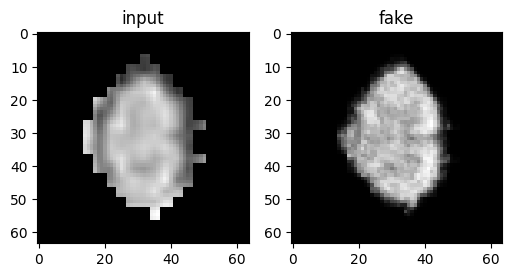

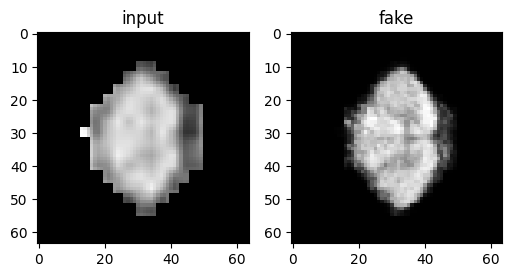

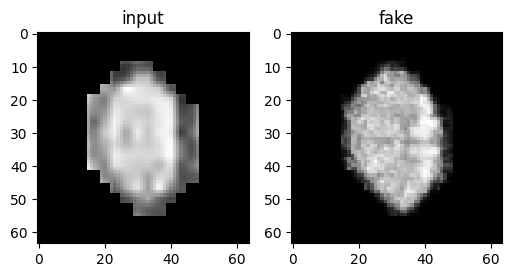

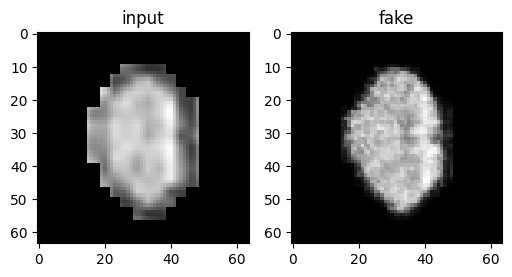

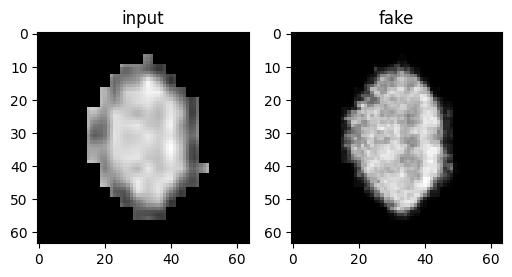

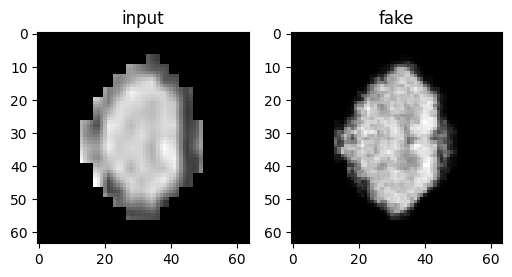

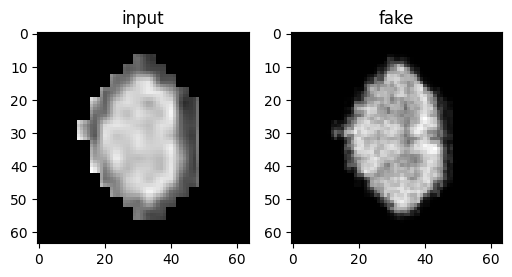

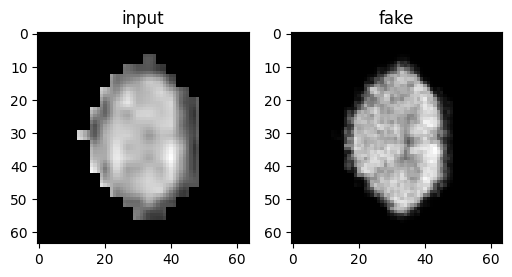

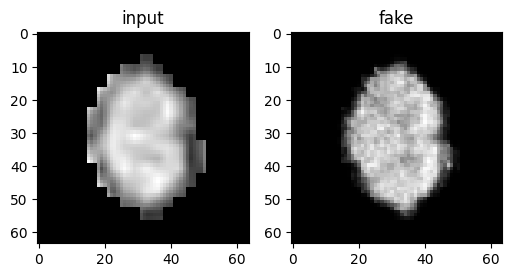

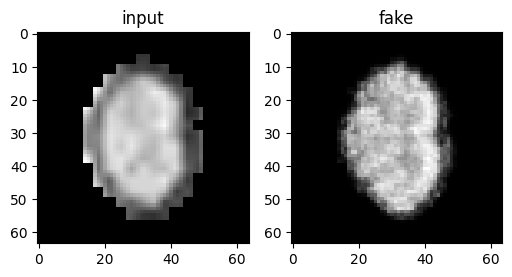

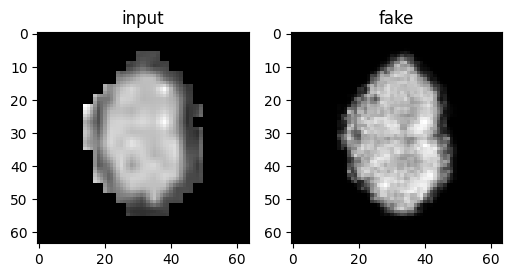

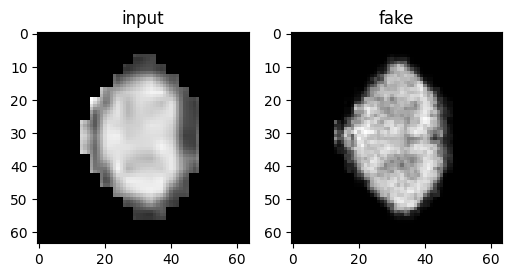

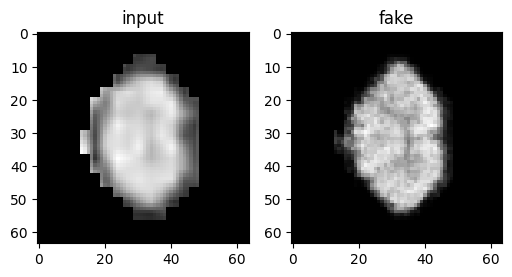

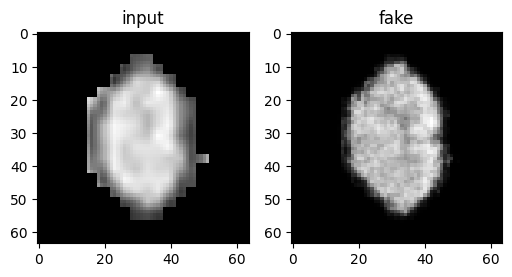

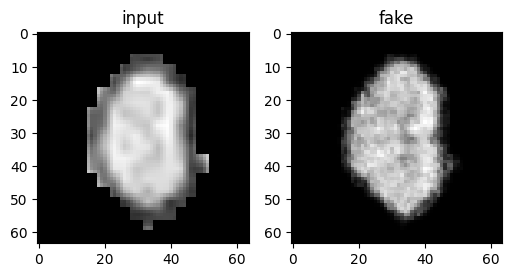

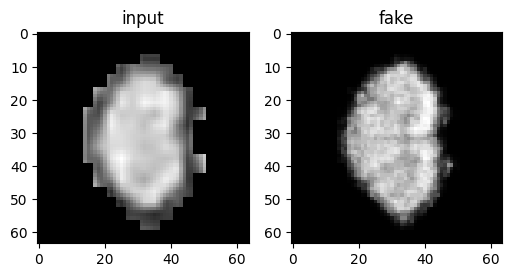

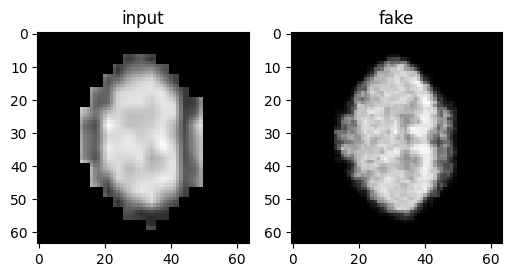

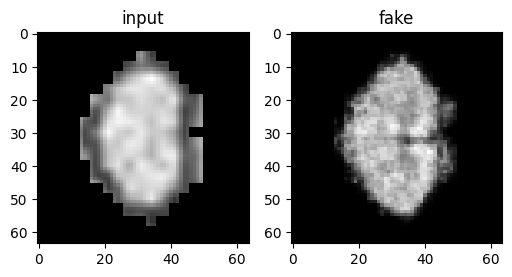

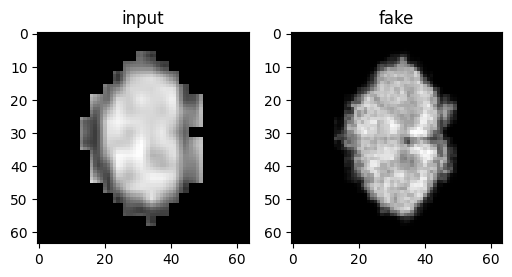

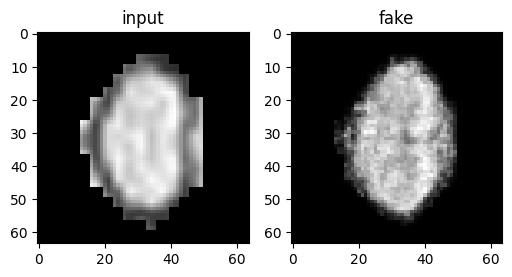

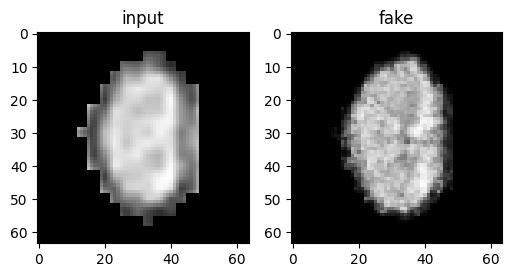

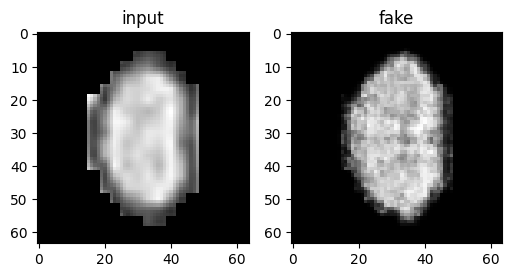

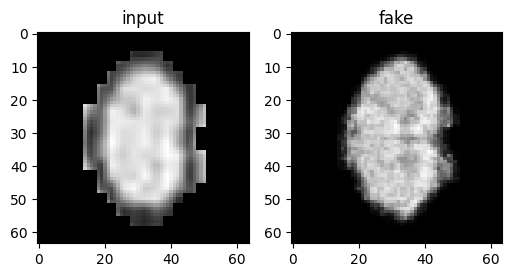

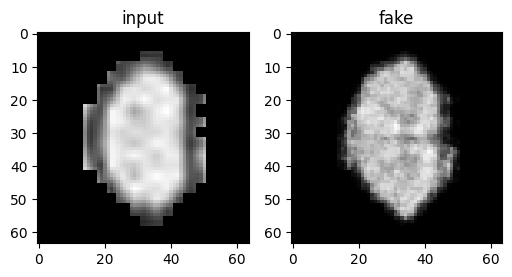

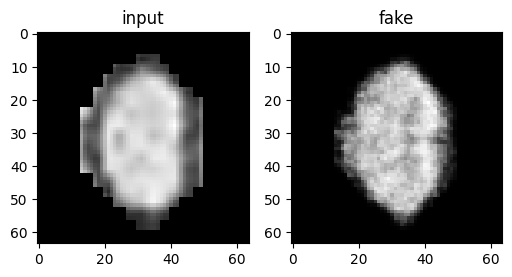

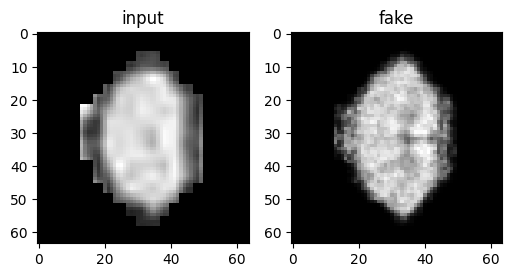

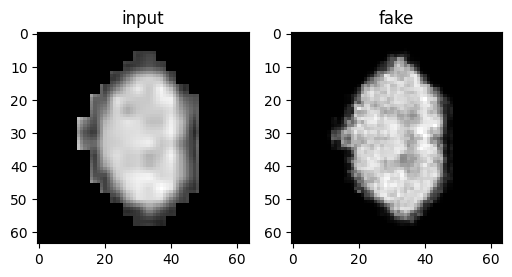

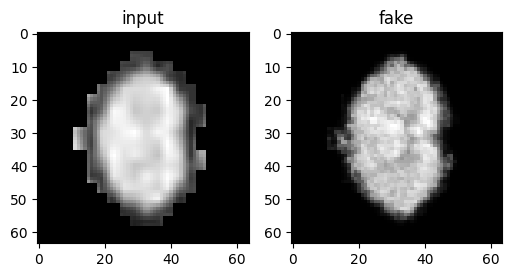

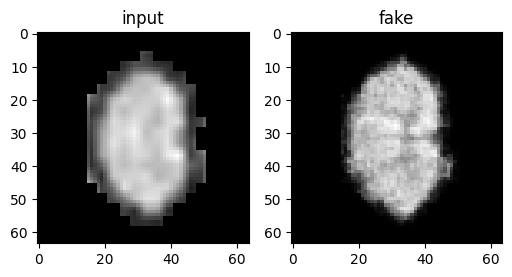

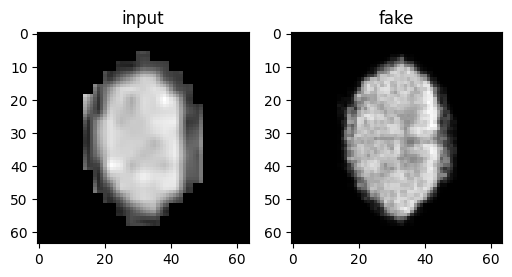

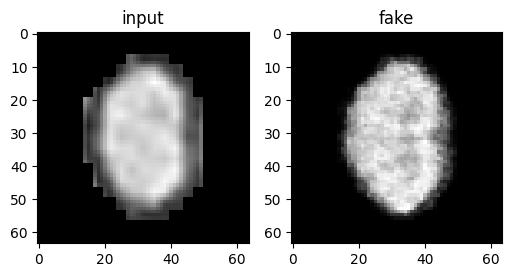

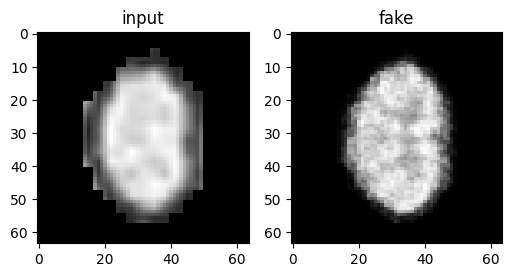

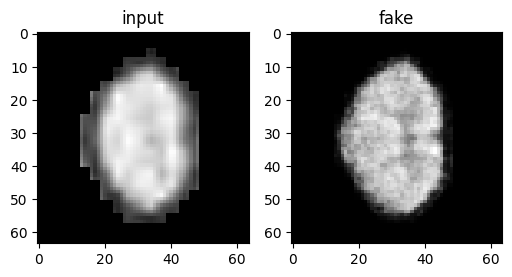

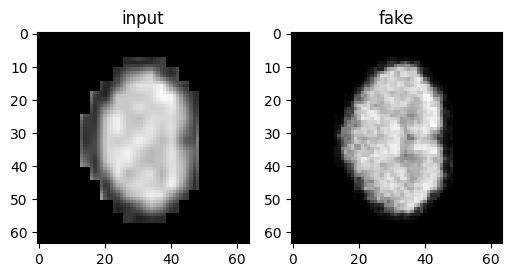

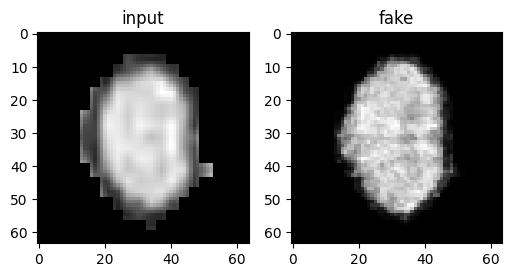

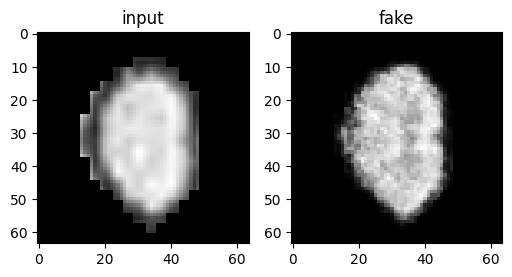

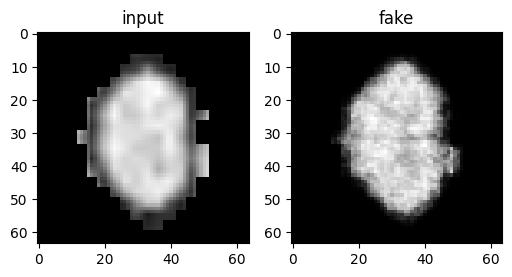

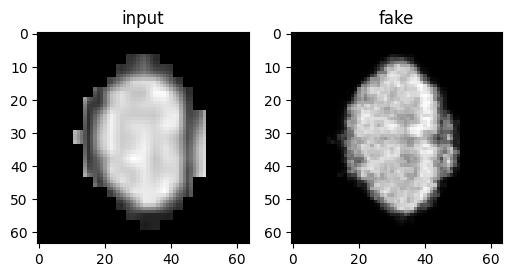

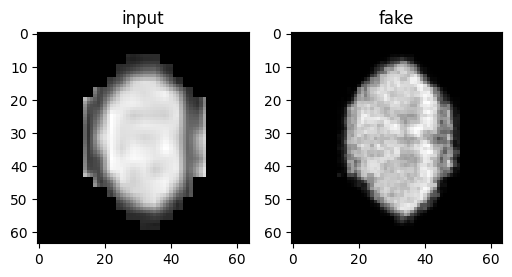

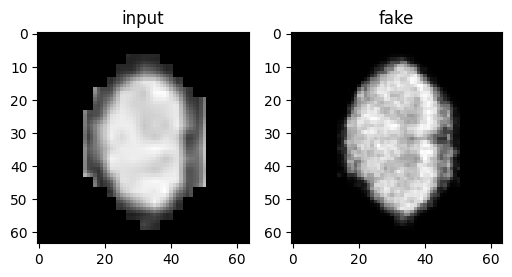

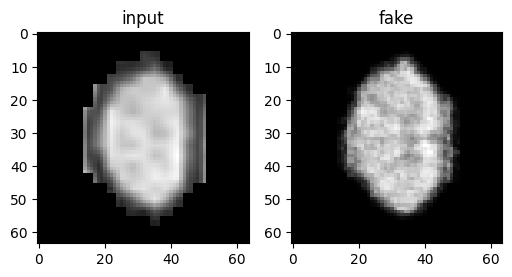

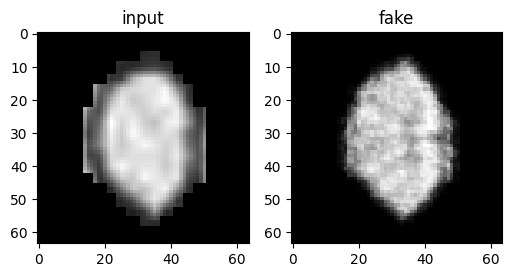

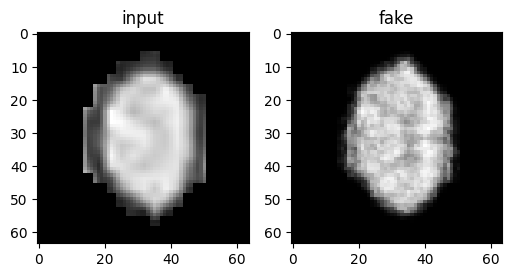

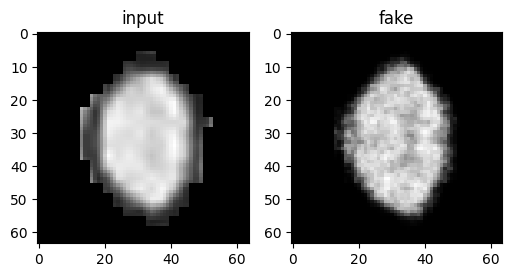

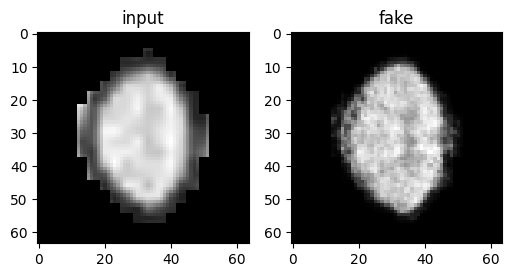

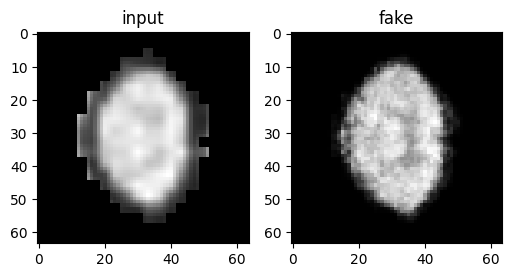

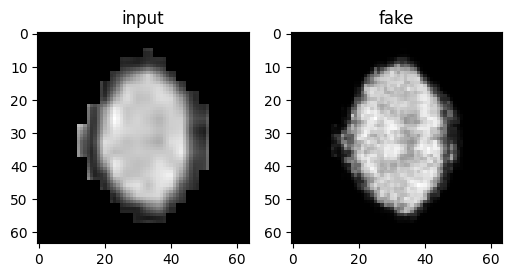

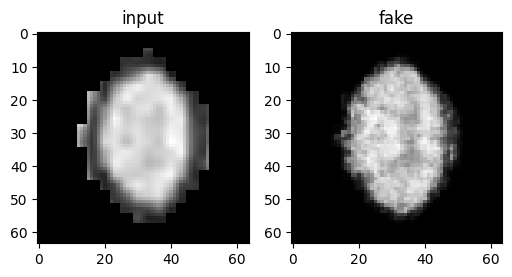

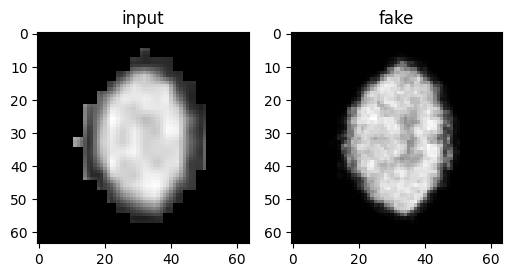

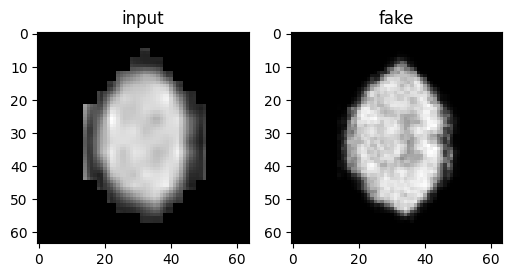

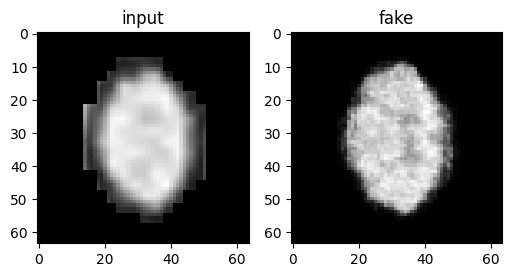

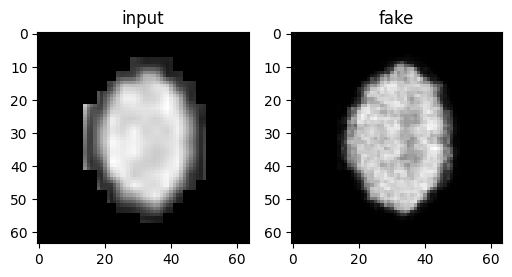

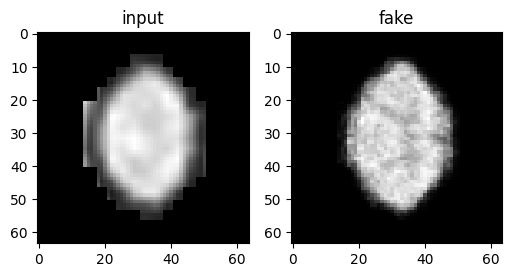

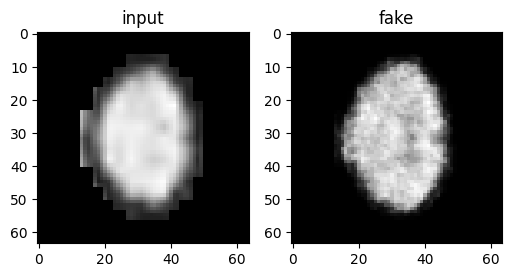

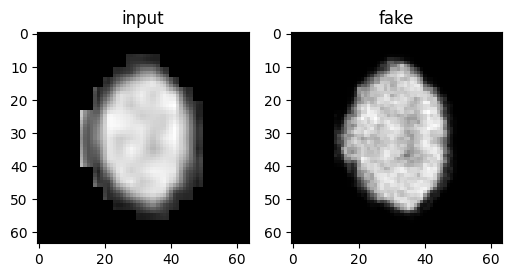

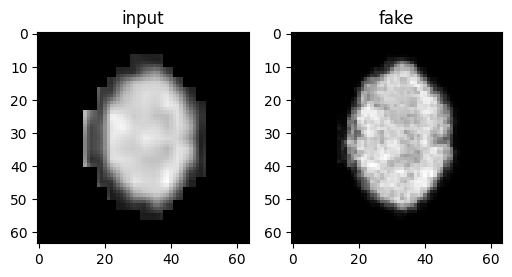

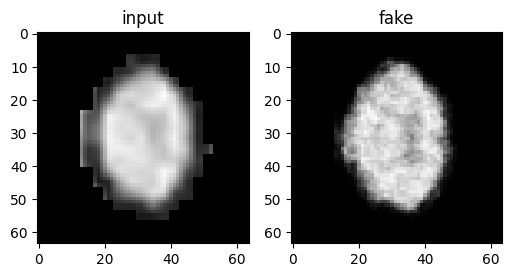

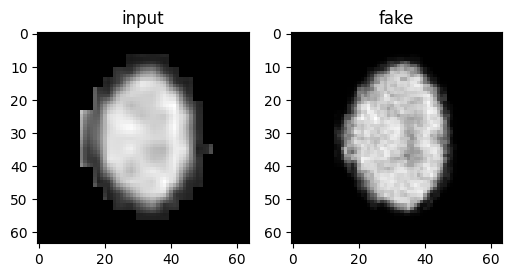

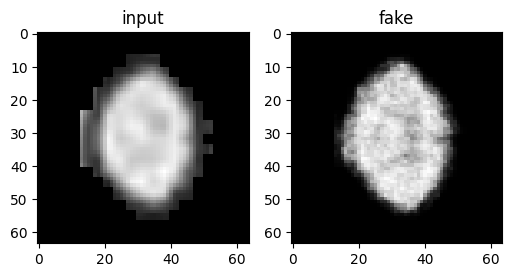

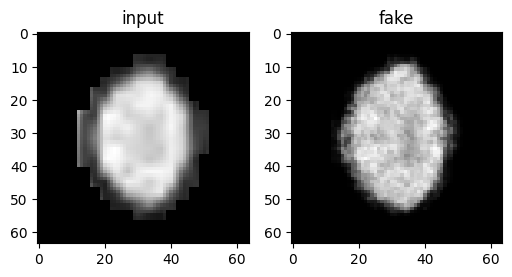

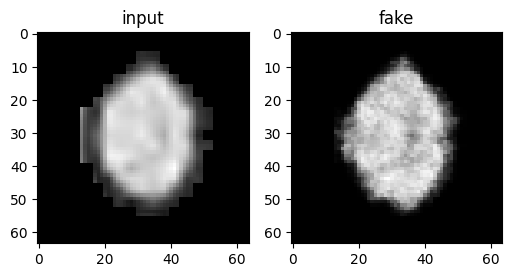

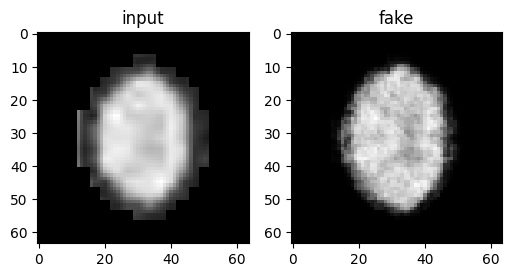

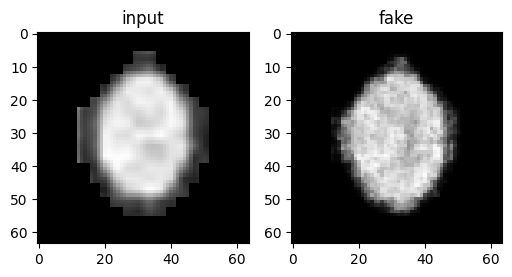

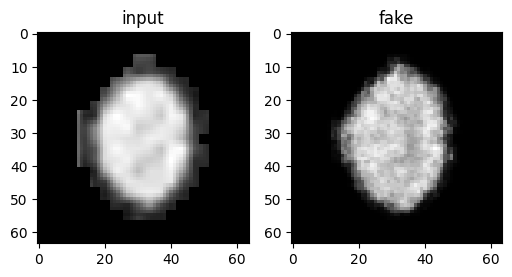

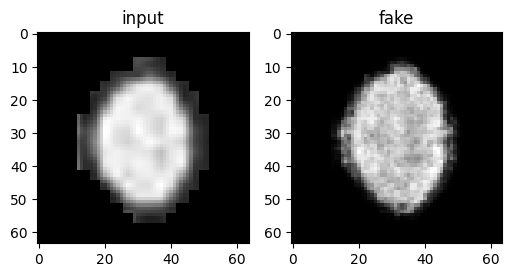

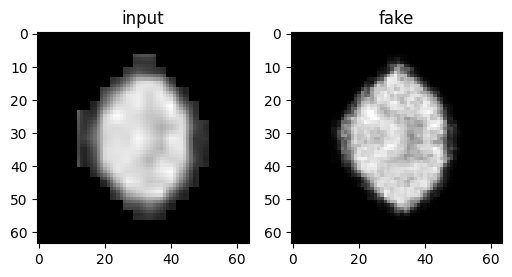

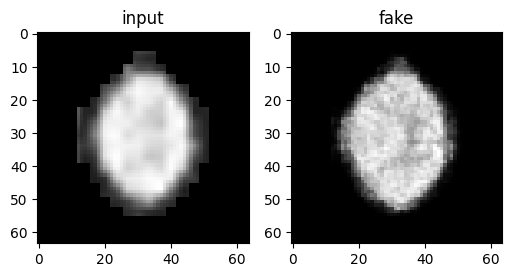

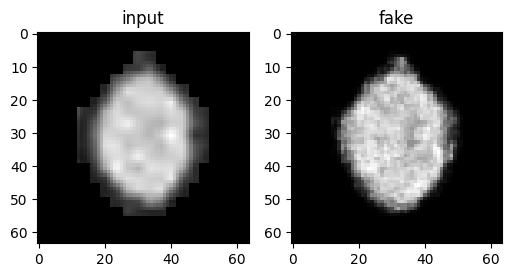

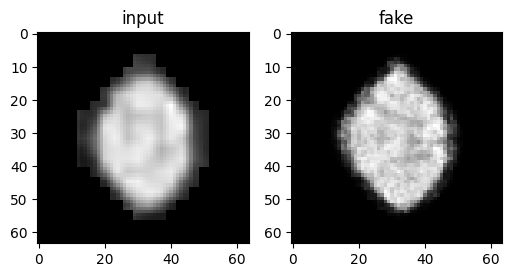

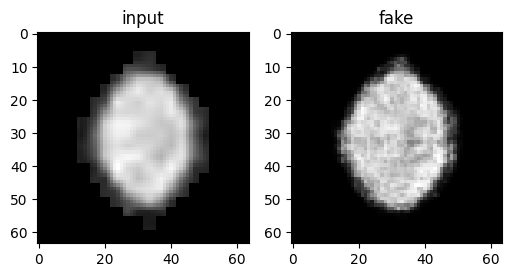

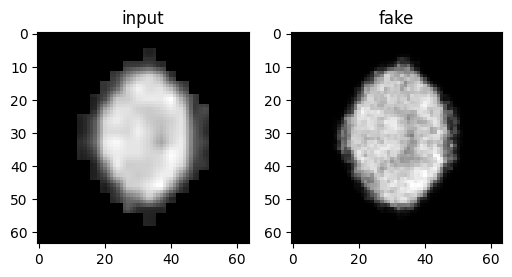

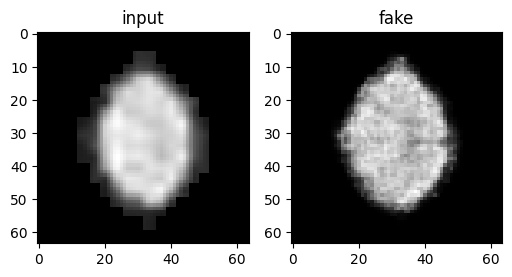

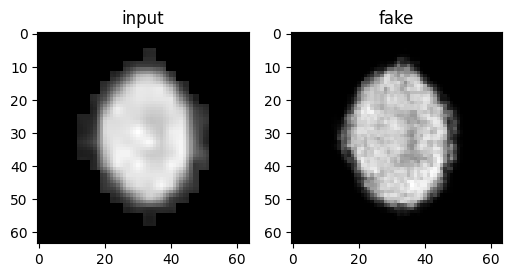

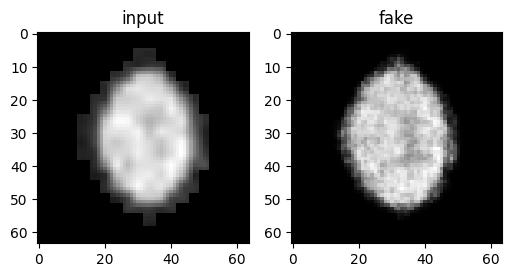

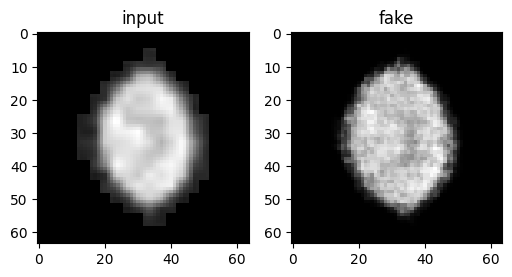

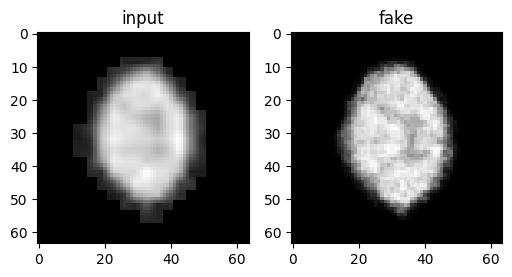

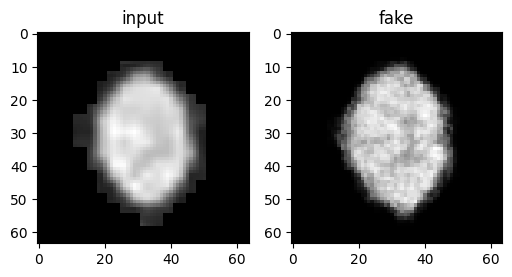

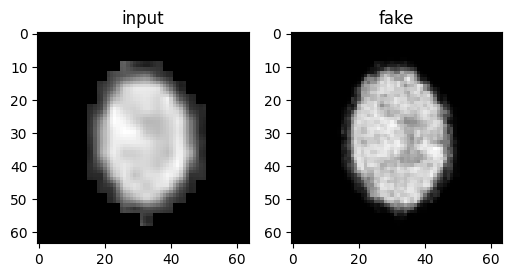

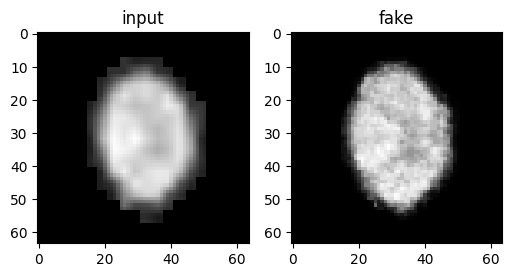

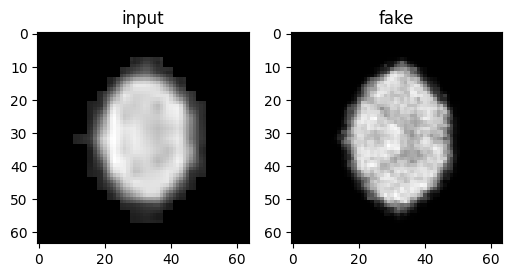

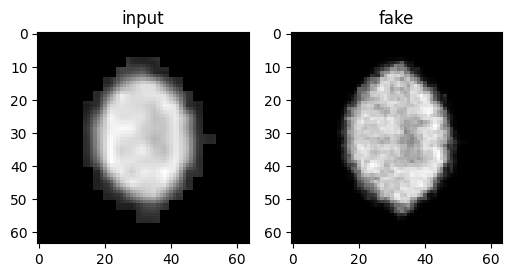

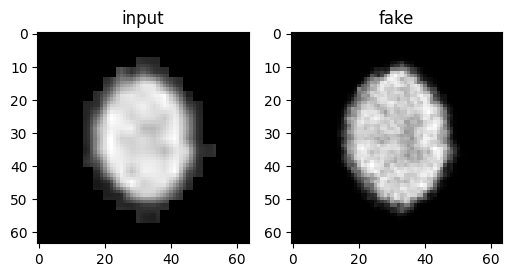

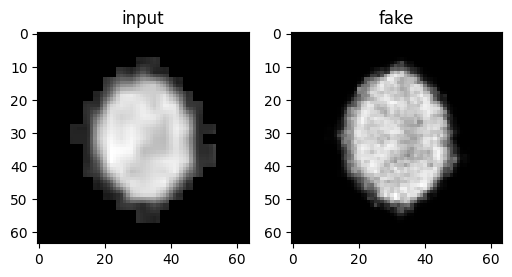

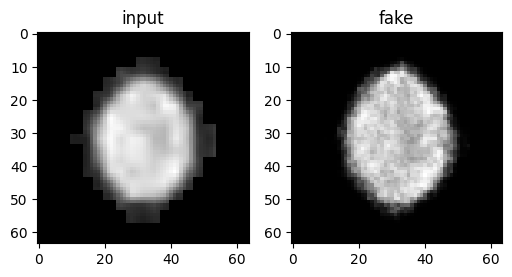

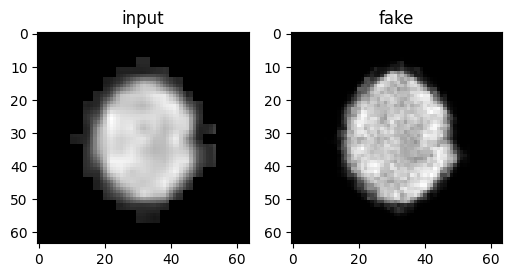

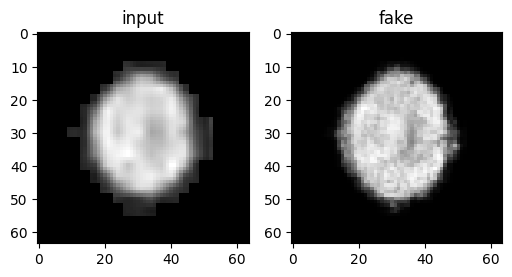

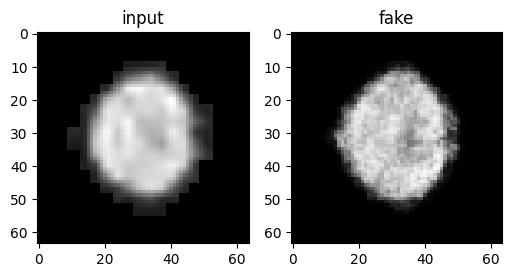

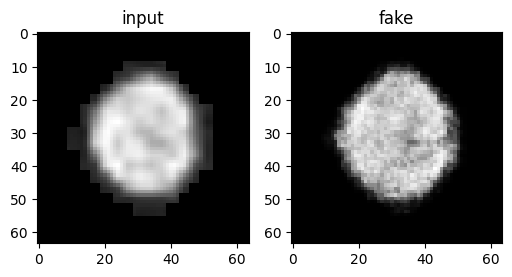

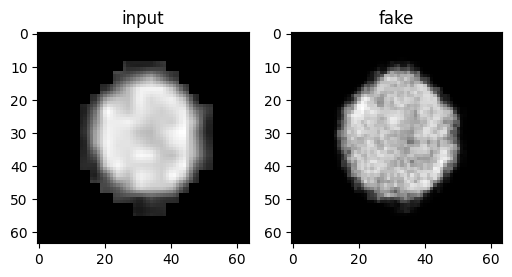

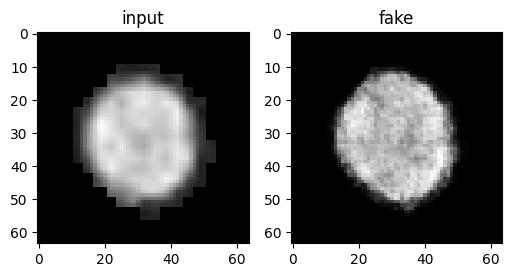

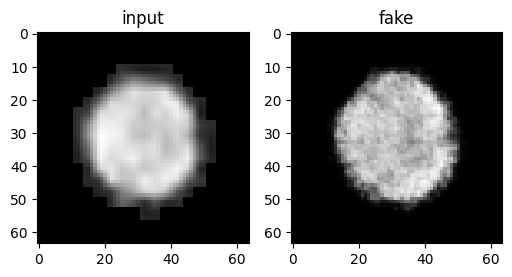

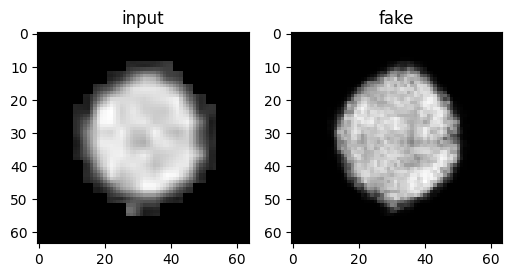

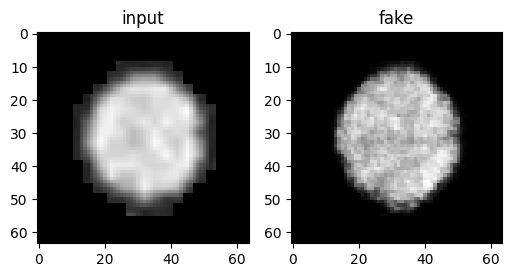

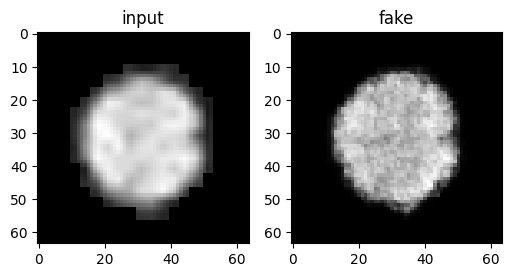

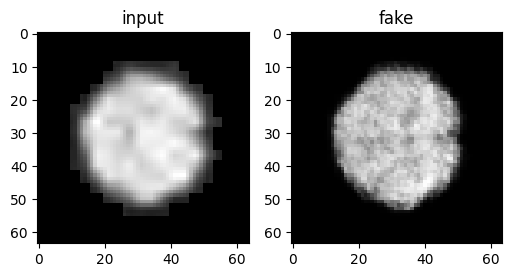

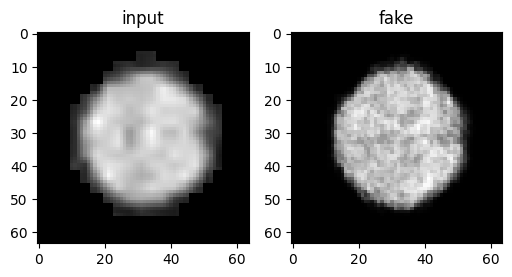

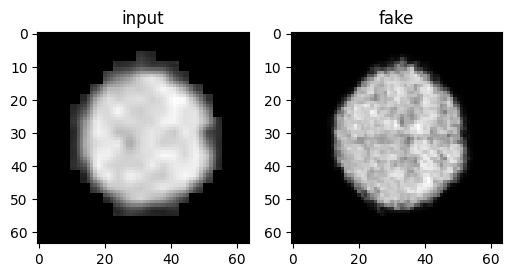

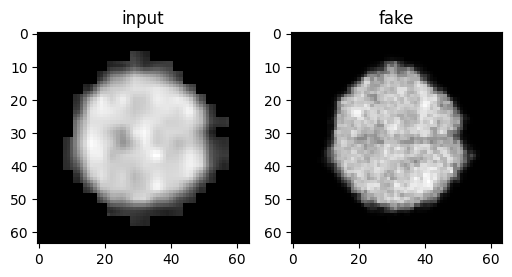

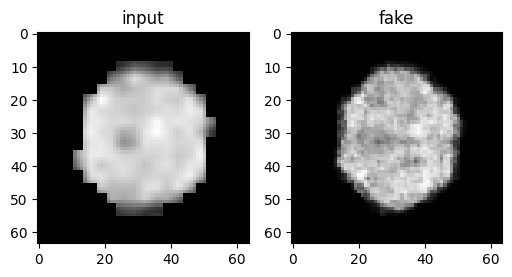

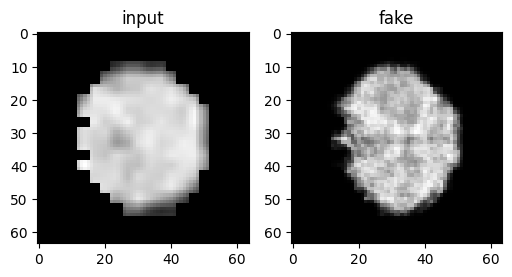

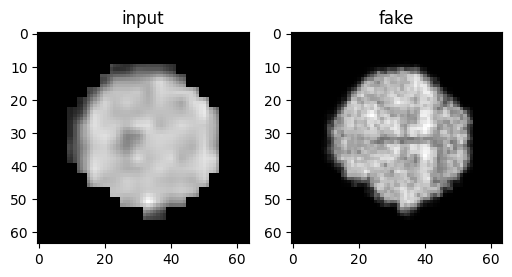

In [413]:
# HC 
generator_cgan = generator_cgan

Size_X= 64
Size_Y= 64
Size_Z=(image_sc.shape)[2]
image_pad_3TMP2RAGE=np.zeros((Size_X,Size_Y,Size_Z))
padding_x_y = ((50, 50), (50, 50), (0, 0))
image_paded_3TMP2RAGE = np.pad(image_3TMP2RAGE, padding_x_y , 'constant')    
image_paded_sc = np.pad(image_sc, padding_x_y , 'constant')   
image_paded_lesion = np.pad(image_lesion, padding_x_y , 'constant')   

image_paded_center = np.zeros(image_paded_3TMP2RAGE.shape)
print (image_paded_3TMP2RAGE.shape)
for i in range (Size_Z):
    x,y=ndimage.measurements.center_of_mass(image_paded_sc[:,:,i])
    x,y=int(round(x)),int(round(y))
    xmin = x - 32
    xmax = x + 32
    ymin = y - 32
    ymax = y + 32
    array=image_paded_3TMP2RAGE[xmin:xmax,ymin:ymax,i] 
    x = torch.tensor(array)
    x_new = x[None, None, :]
    Size_X=(x_new.shape)[2]
    Size_Y=(x_new.shape)[3]
    Size_Z= 1
    d = generator_cgan(x_new[:,:,:].type(Tensor)).cpu().detach().numpy()
    image_pad_3TMP2RAGE[:,:,i]=d
    padding_x_y_ii = ((xmin, image_paded_3TMP2RAGE.shape[0] - xmax), (ymin, image_paded_3TMP2RAGE.shape[1] - ymax) )
    image_paded_center[:,:,i] = np.pad(image_pad_3TMP2RAGE[:,:,i], padding_x_y_ii , 'constant', constant_values=-1) 
    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x_new[0,0,:,:])
    plt.title("input")
    plt.subplot(1, 2, 2)
    plt.imshow((image_pad_3TMP2RAGE[:,:,i]))
    plt.title("fake")
    plt.show()

In [414]:
new_image = (image_paded_center + 1) * max_pixel/2 # to save the image in a range as original image

patch = '/mnt/d/Poly/test_gan/'
LE = nib.Nifti1Image(new_image, image_data_LE.affine)
nib.save(LE, patch + 'C011_UNIT1_fake.nii.gz' )

LE = nib.Nifti1Image(image_paded_sc, image_data_LE.affine)
nib.save(LE, patch + 'C011_UNIT1_sc_fake.nii.gz' )
